In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from itertools import combinations
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
import pickle
from pyclustering.cluster.cure import cure
from tqdm.notebook import tqdm
from scipy.stats import chi2

In [2]:
df = pd.read_csv('CC GENERAL.csv')
df.drop('CUST_ID', axis=1, inplace=True)
print(f'Number of entries: {df.shape[0]}')
print(df.isnull().sum())

Number of entries: 8950
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64


In [3]:
idx = df[(df['MINIMUM_PAYMENTS'].isnull()) | (df['MINIMUM_PAYMENTS'] > df['PAYMENTS'])].index
df.drop(idx, inplace=True)
print(f'Number of entries: {df.shape[0]}')
df.to_csv('CC_GENERAL_CLEANED.csv', index=False)

Number of entries: 6272


In [4]:
print(df.isnull().sum())

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64


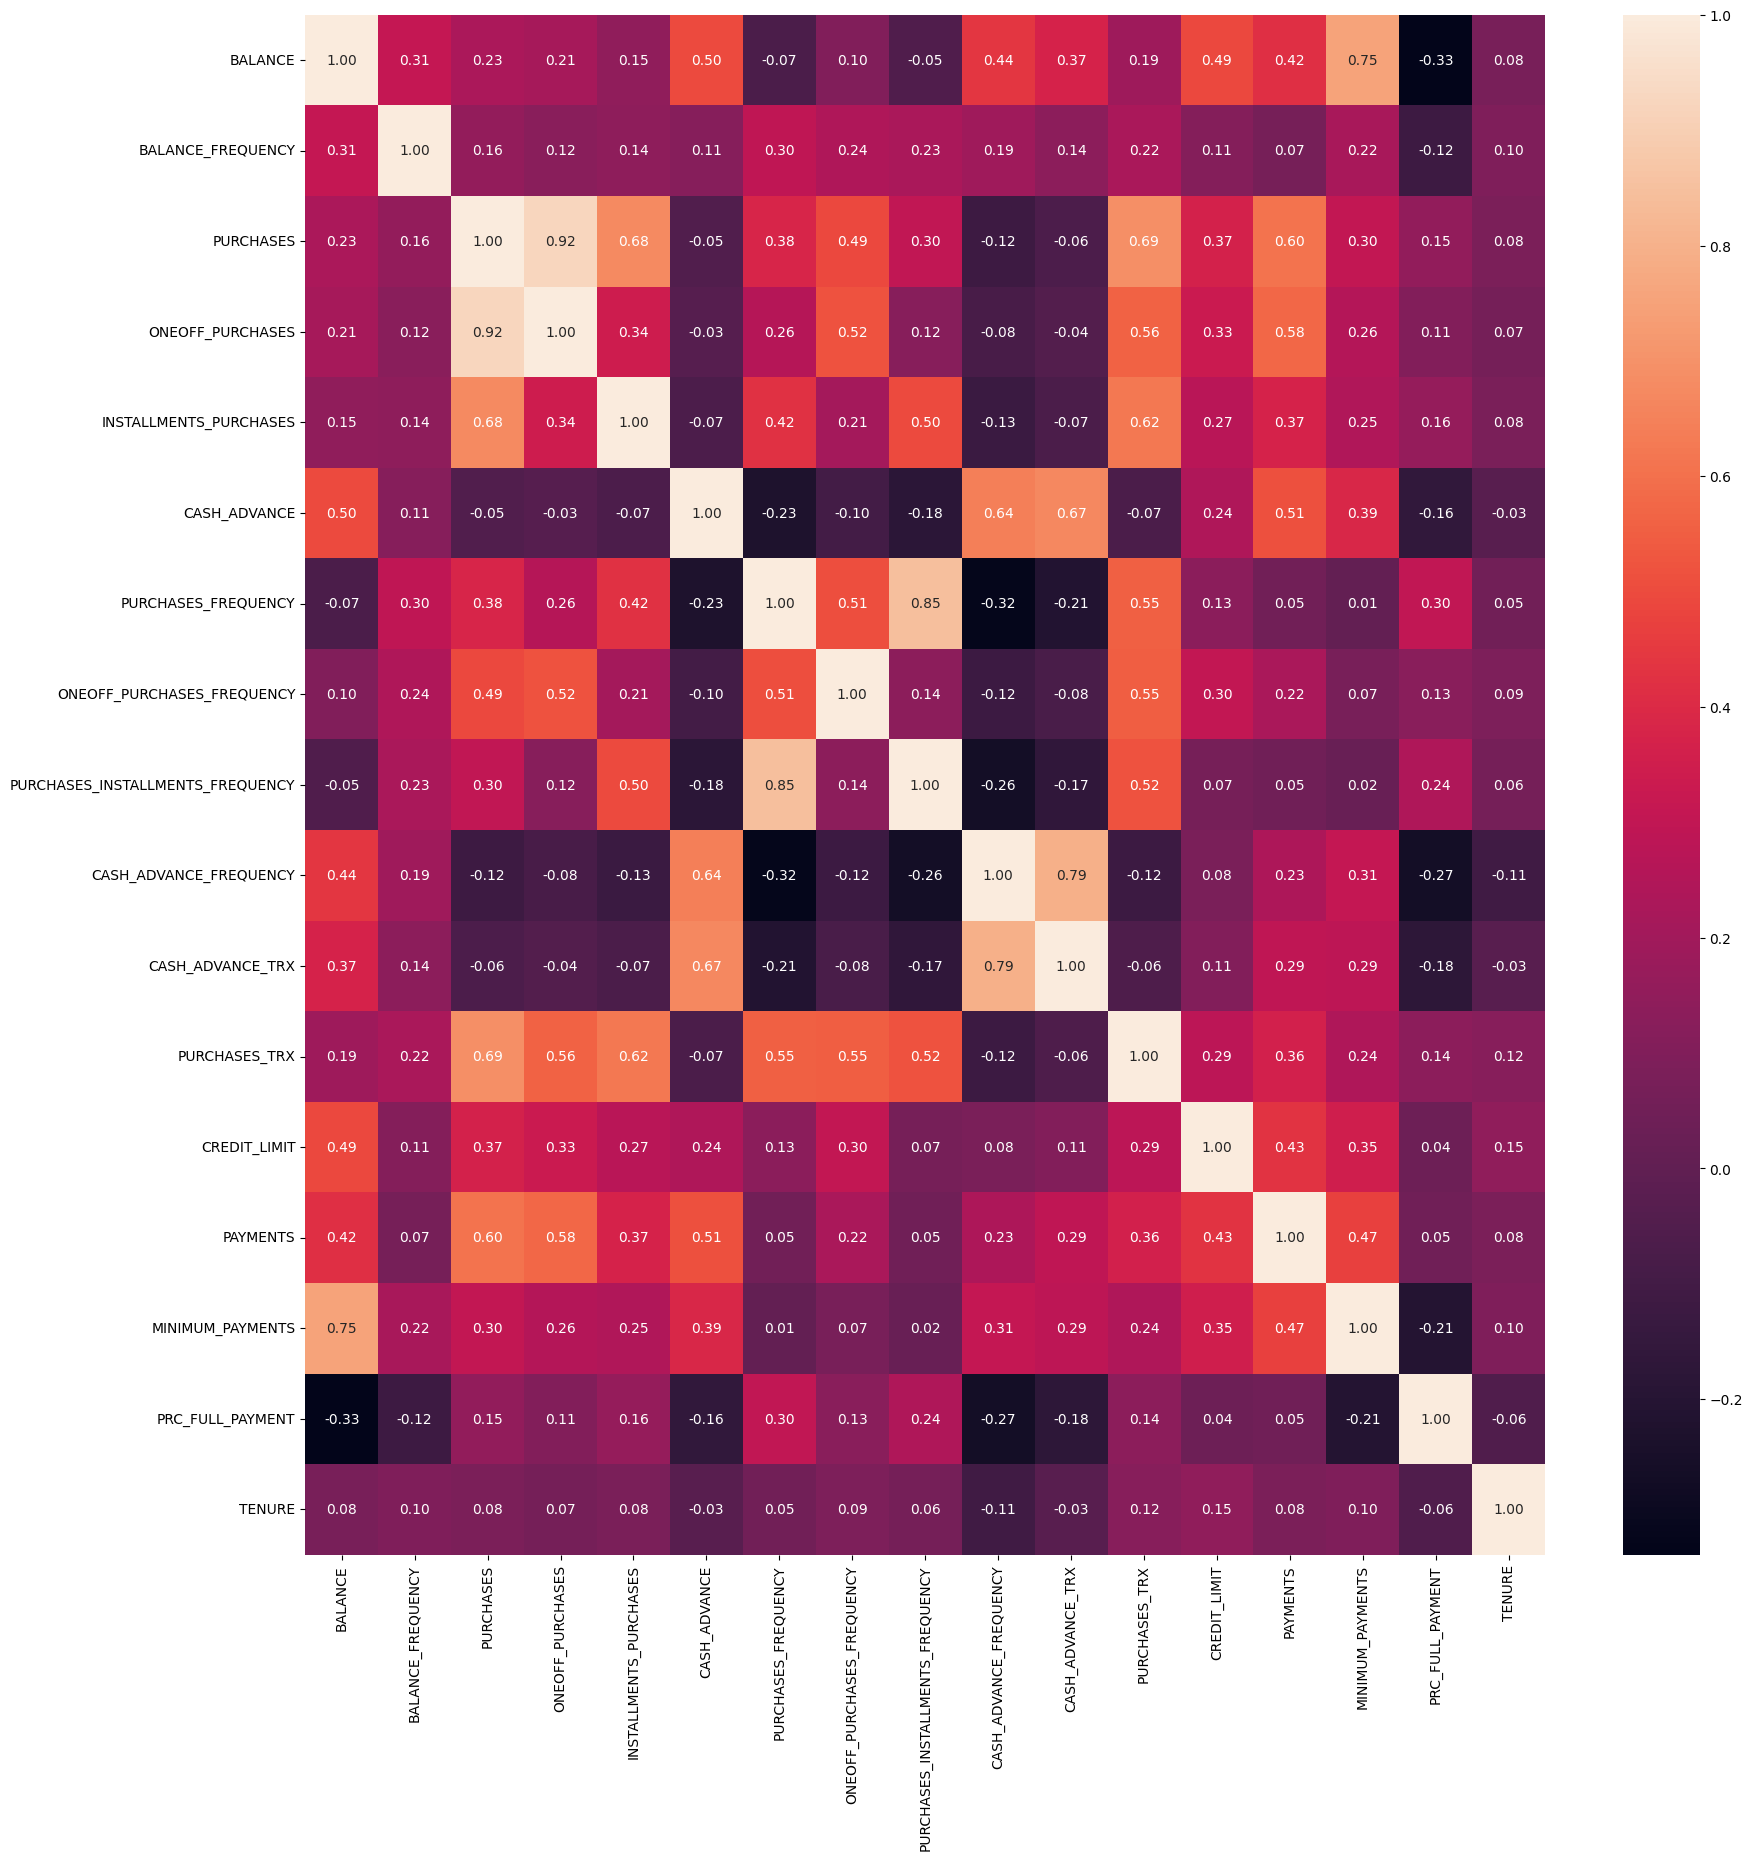

In [5]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, fmt='.2f')
plt.show()

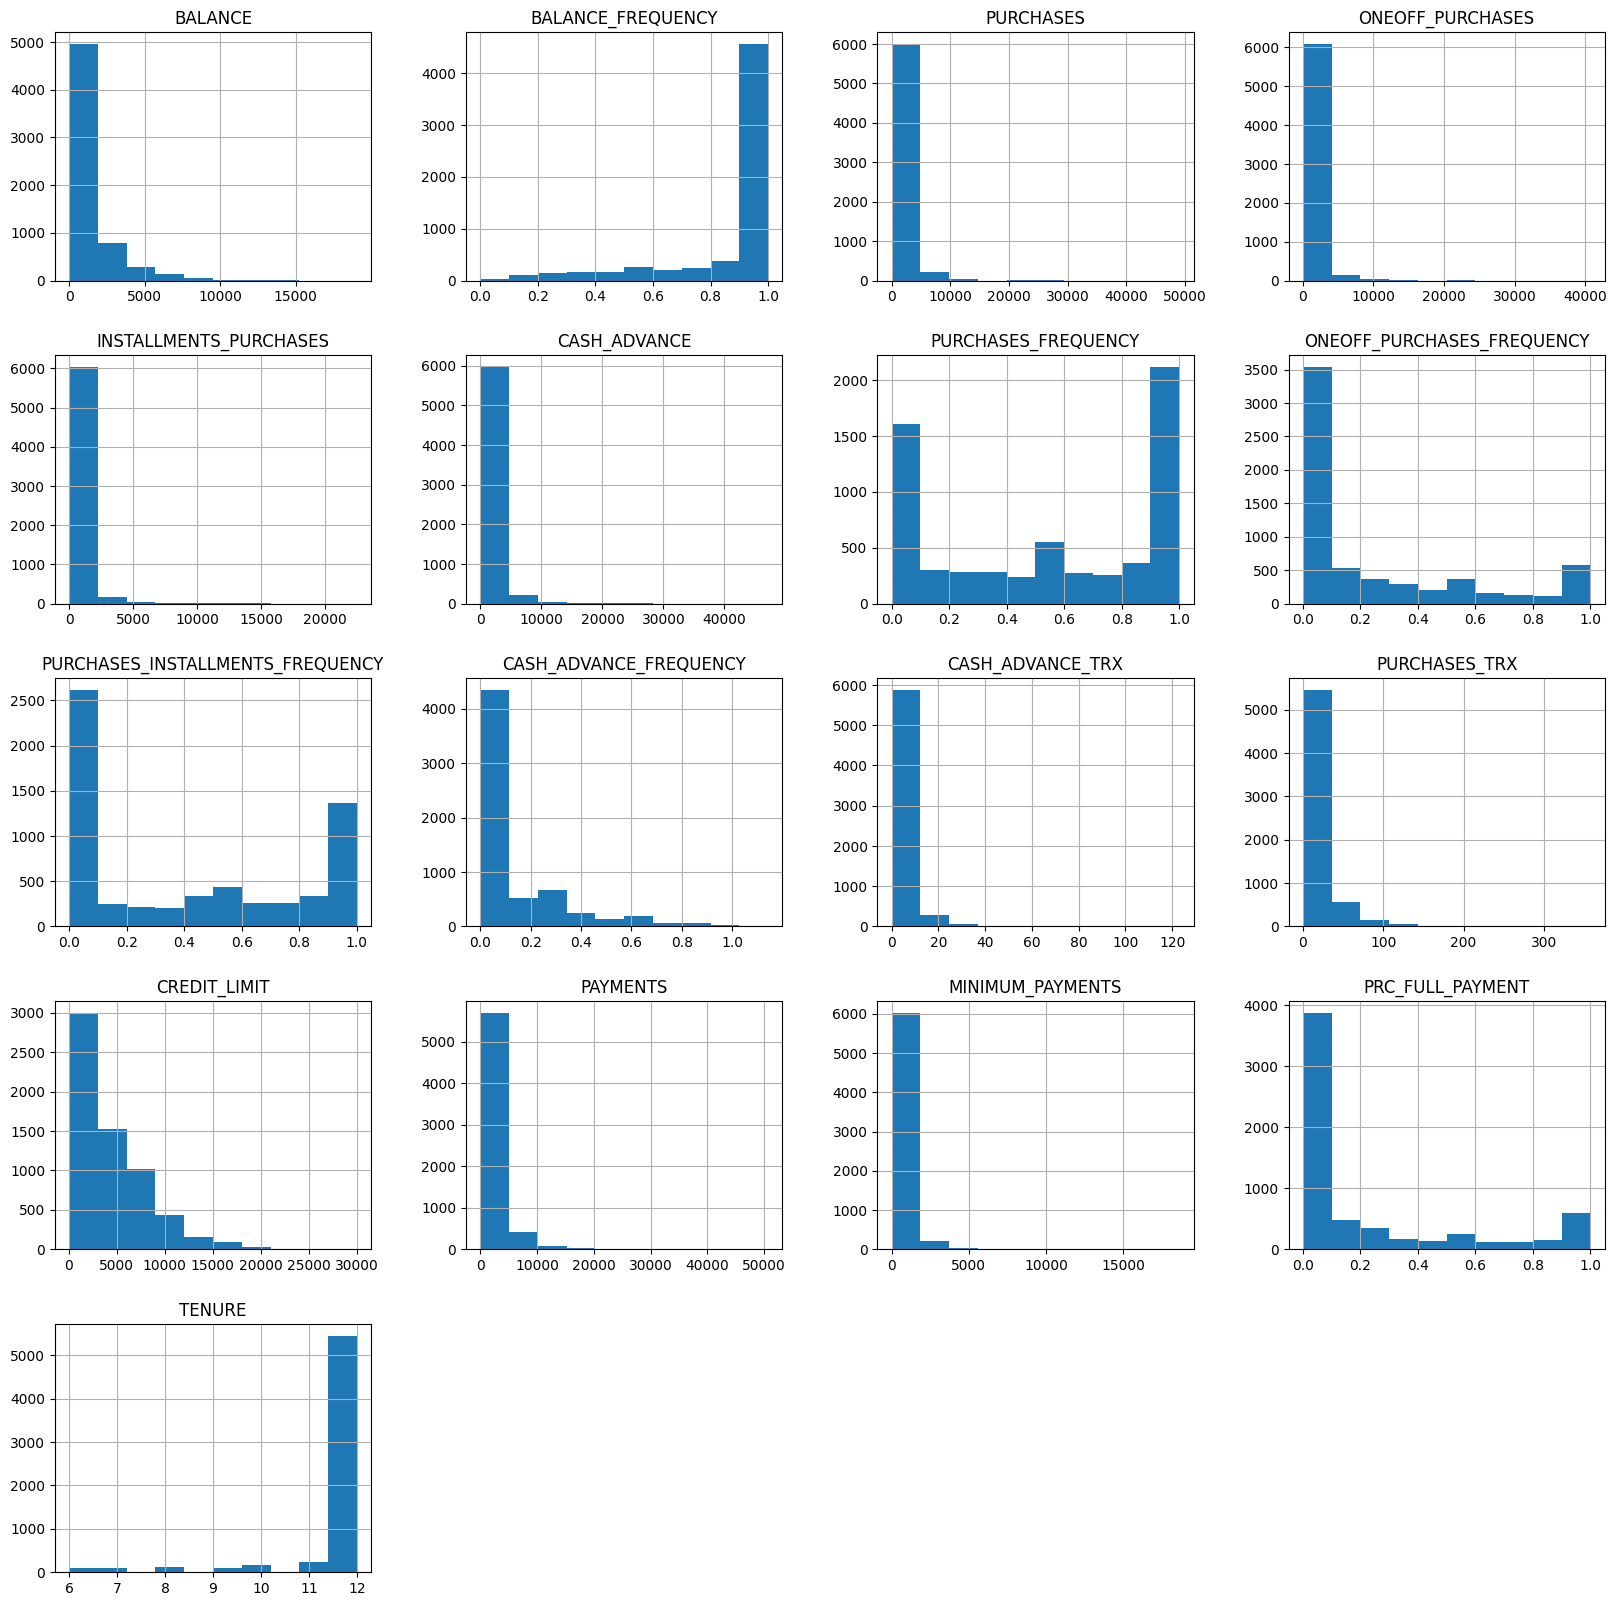

In [6]:
df.hist(figsize=(20, 20))
plt.show()

## Computing statistics using data analytics approach based on BFR method

In [7]:
class ColumnStatistics:
    def __init__(self, name):
        self.name = name
        self.N = 0
        self.sum = 0
        self.sum2 = 0
    
    def get_mean(self):
        return self.sum / self.N
    
    def get_std(self):
        return np.sqrt(self.sum2 / self.N - (self.sum / self.N) ** 2)
    
    def get_N(self):
        return self.N
    

def get_statistics(path_to_csv):
    i = -1
    columns = []
    for line in open(path_to_csv):
        if i == -1:
            columns = line.strip().split(',')[1:]
            statistics = {column: ColumnStatistics(column) for column in columns}
        else:
            values = line.strip().split(',')[1:]
            for j in range(0,len(values)):
                if values[j] == '':
                    continue
                statistics[columns[j]].N += 1
                statistics[columns[j]].sum += float(values[j])
                statistics[columns[j]].sum2 += float(values[j]) ** 2
        i += 1
    return statistics

stats = get_statistics('CC_GENERAL_CLEANED.csv')
for stat in stats.keys():
    print(f"{stat}, N: {stats[stat].get_N()}, Mean: {stats[stat].get_mean():.2f}, Std: {stats[stat].get_std():.2f}")

BALANCE_FREQUENCY, N: 6272, Mean: 0.88, Std: 0.22
PURCHASES, N: 6272, Mean: 1213.19, Std: 2428.63
ONEOFF_PURCHASES, N: 6272, Mean: 724.77, Std: 1901.20
INSTALLMENTS_PURCHASES, N: 6272, Mean: 488.72, Std: 999.47
CASH_ADVANCE, N: 6272, Mean: 920.55, Std: 2207.59
PURCHASES_FREQUENCY, N: 6272, Mean: 0.54, Std: 0.40
ONEOFF_PURCHASES_FREQUENCY, N: 6272, Mean: 0.24, Std: 0.32
PURCHASES_INSTALLMENTS_FREQUENCY, N: 6272, Mean: 0.40, Std: 0.40
CASH_ADVANCE_FREQUENCY, N: 6272, Mean: 0.12, Std: 0.20
CASH_ADVANCE_TRX, N: 6272, Mean: 2.96, Std: 7.12
PURCHASES_TRX, N: 6272, Mean: 17.10, Std: 27.01
CREDIT_LIMIT, N: 6272, Mean: 4733.73, Std: 3747.75
PAYMENTS, N: 6272, Mean: 2148.49, Std: 3285.23
MINIMUM_PAYMENTS, N: 6272, Mean: 475.52, Std: 757.36
PRC_FULL_PAYMENT, N: 6272, Mean: 0.21, Std: 0.33
TENURE, N: 6272, Mean: 11.61, Std: 1.19


In [8]:
with open('stats.pkl', 'wb') as f:
    pickle.dump(stats, f)

In [9]:
path_to_file = 'CC_GENERAL_CLEANED.csv'
number_lines = sum(1 for _ in open(path_to_file)) - 1

number_initial_samples = [2**i for i in range(8,int(np.log2(number_lines)))]
num_clusters = [2,5,10] + [i for i in range(25, 251, 25)]
silhouette_scores = {}

for n in tqdm(number_initial_samples):

    chosen_indices = np.random.choice(number_lines, n, replace=False)
    i=-1
    data = []
    headers = []

    for line in open(path_to_file):
        if i == -1:
            headers = line.strip().split(',')[1:]
        elif i in chosen_indices:
            values = line.strip().split(',')[1:]
            for j,v in enumerate(values):
                if v == '':
                    values[j] = stats[headers[j]].get_mean()
                else:
                    values[j] = float(v)
            data.append(values)
        i += 1

    data = np.array(data)
    silhouette_scores[n] = {}

    for n_clusters in tqdm(num_clusters):
        silhouette_scores[n][n_clusters] = {}
        clustering = AgglomerativeClustering(n_clusters=n_clusters).fit_predict(data)
        silhouette_scores[n][n_clusters]['complete'] = silhouette_score(data, clustering)
        clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='single').fit_predict(data)
        silhouette_scores[n][n_clusters]['single'] = silhouette_score(data, clustering)
        clustering = KMeans(n_clusters=n_clusters).fit_predict(data)
        silhouette_scores[n][n_clusters]['kmeans'] = silhouette_score(data, clustering)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [10]:
with open('silhouette_scores.pkl', 'wb') as f:
    pickle.dump(silhouette_scores, f)

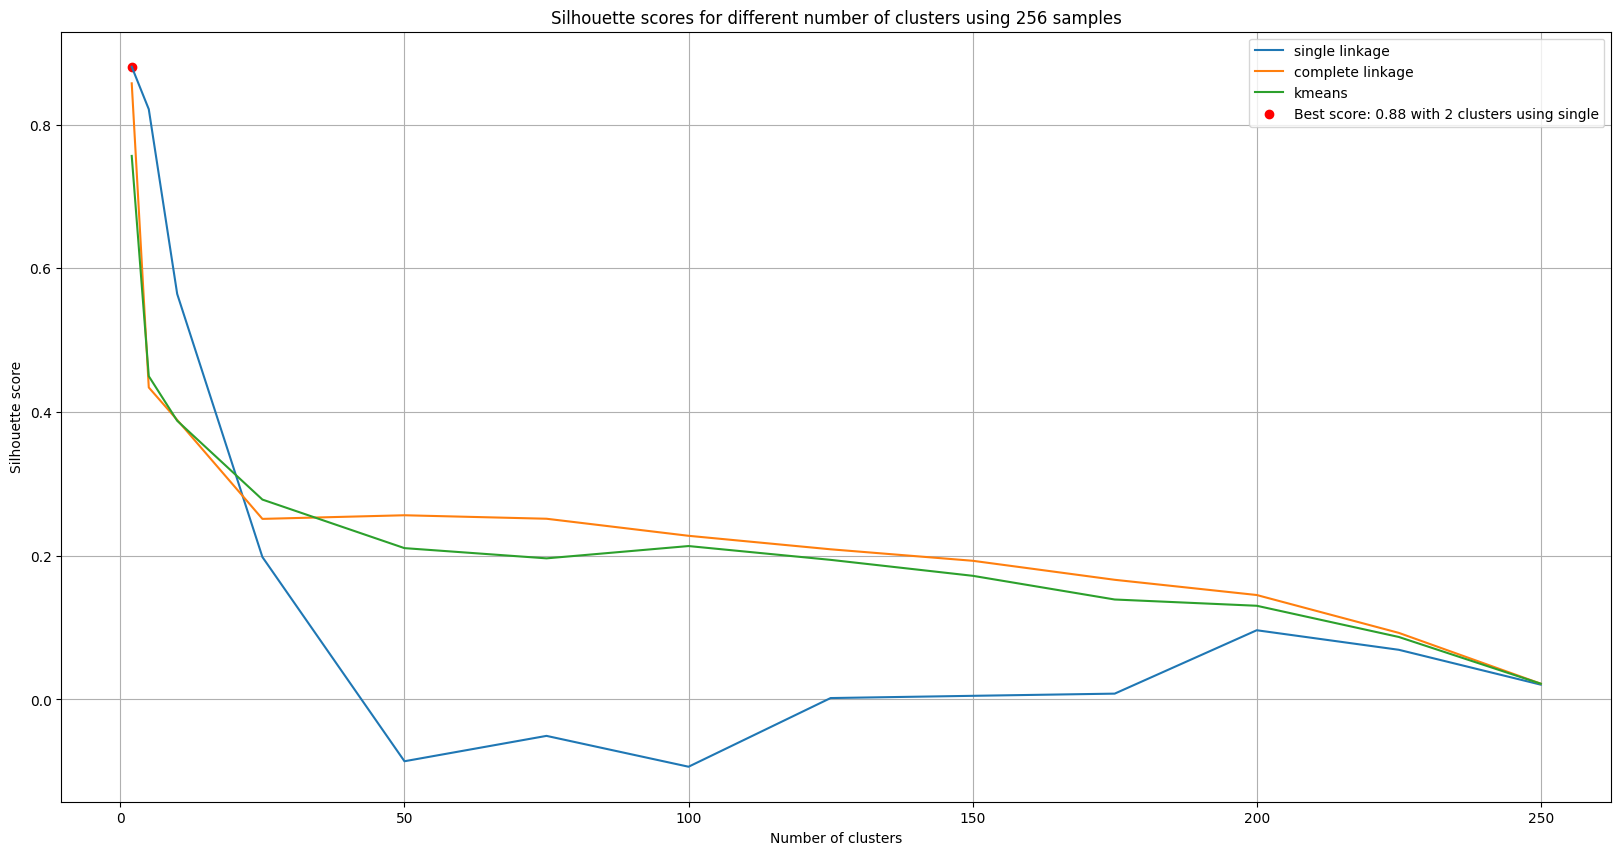

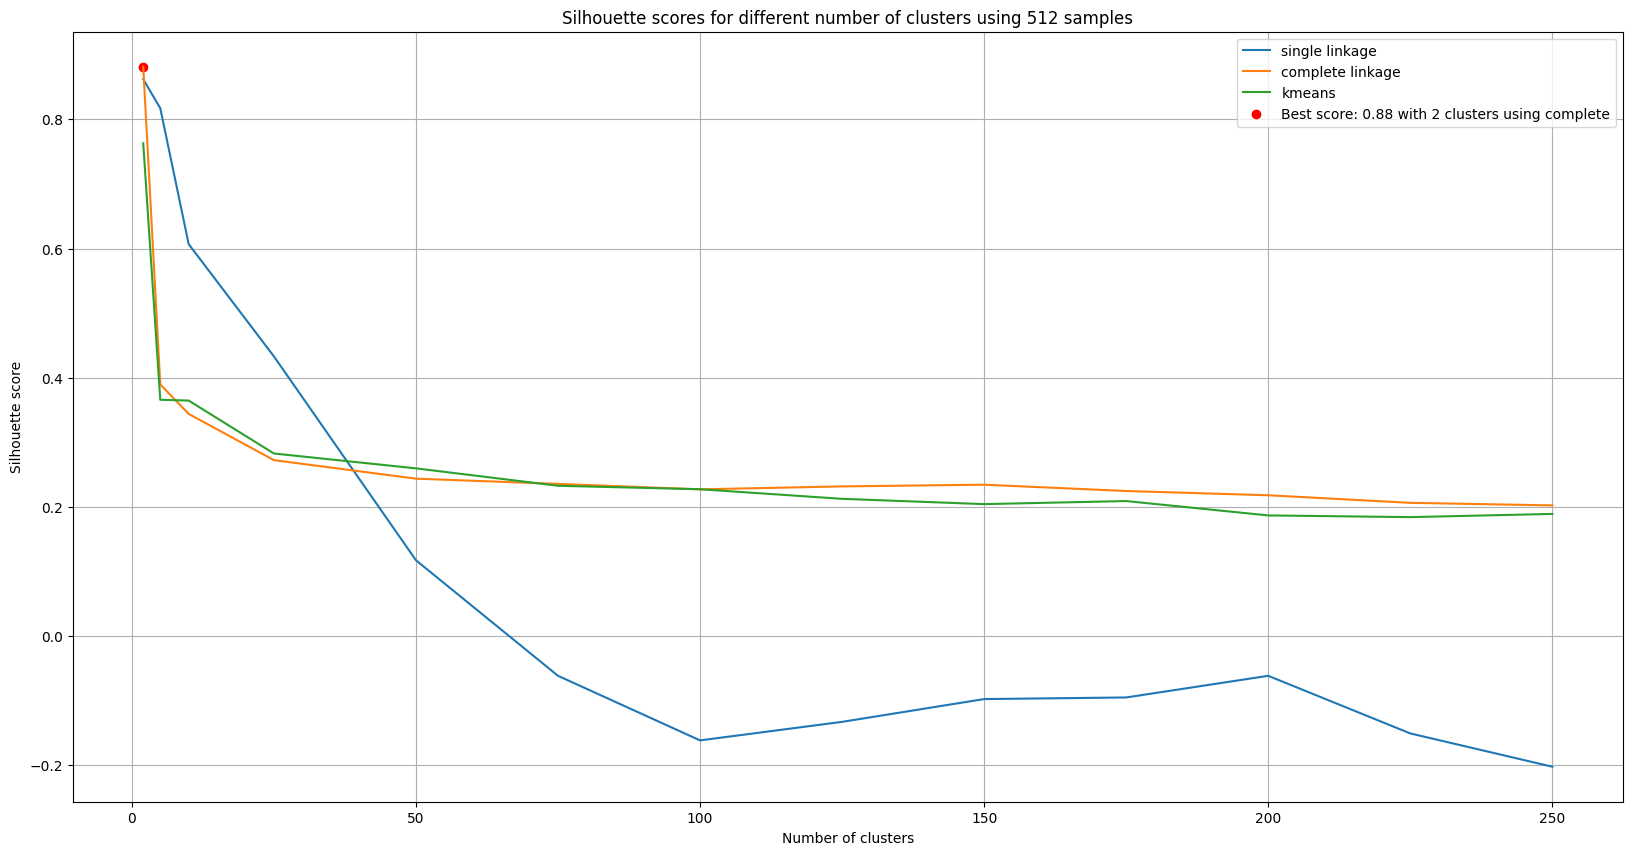

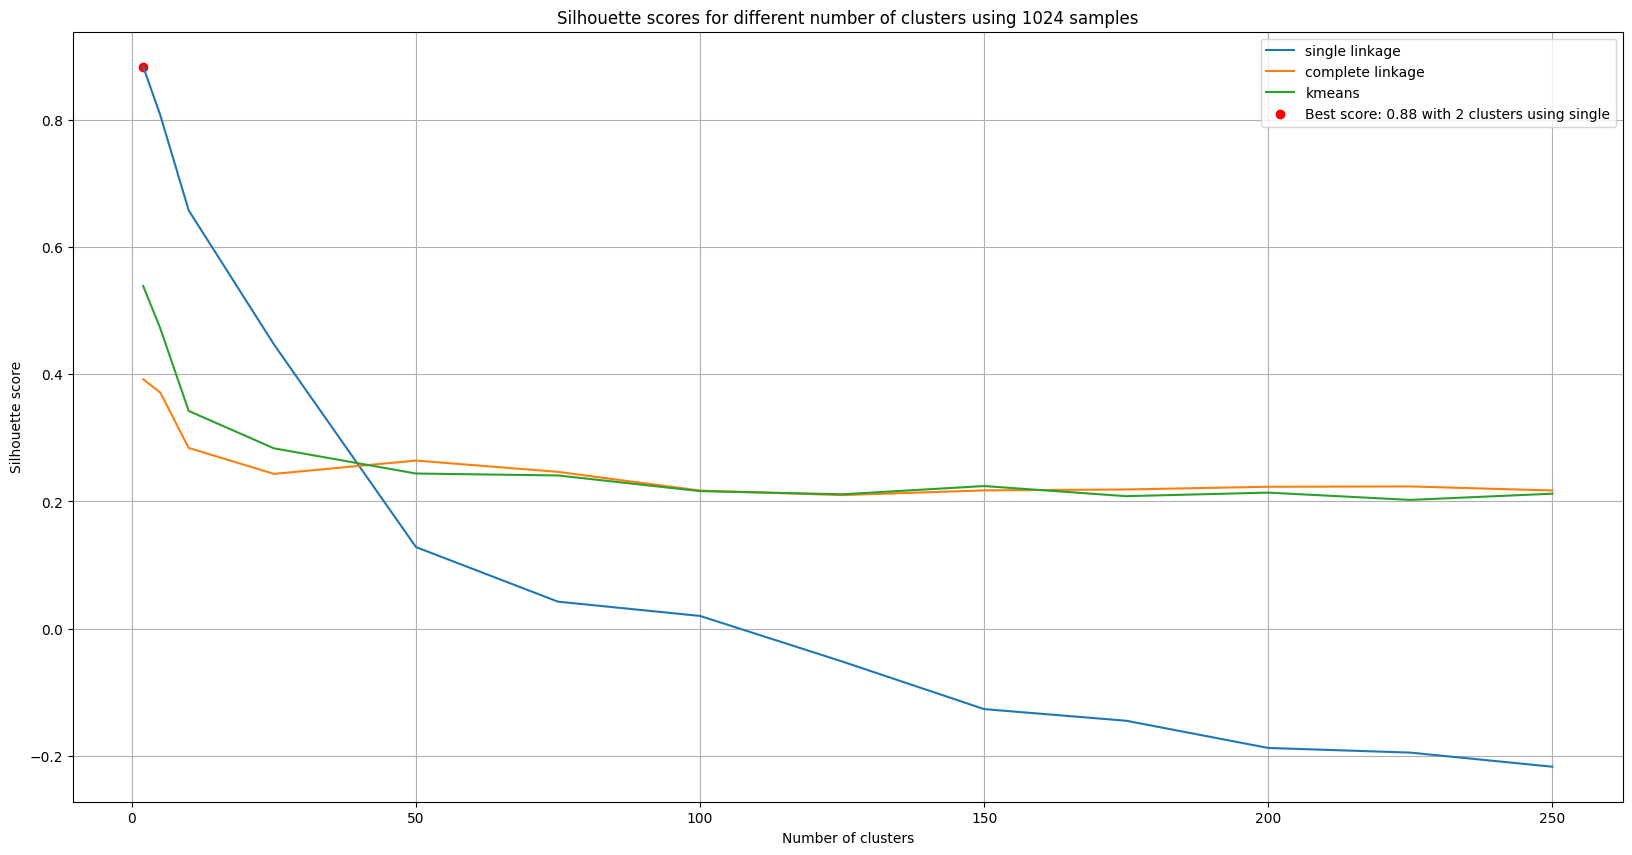

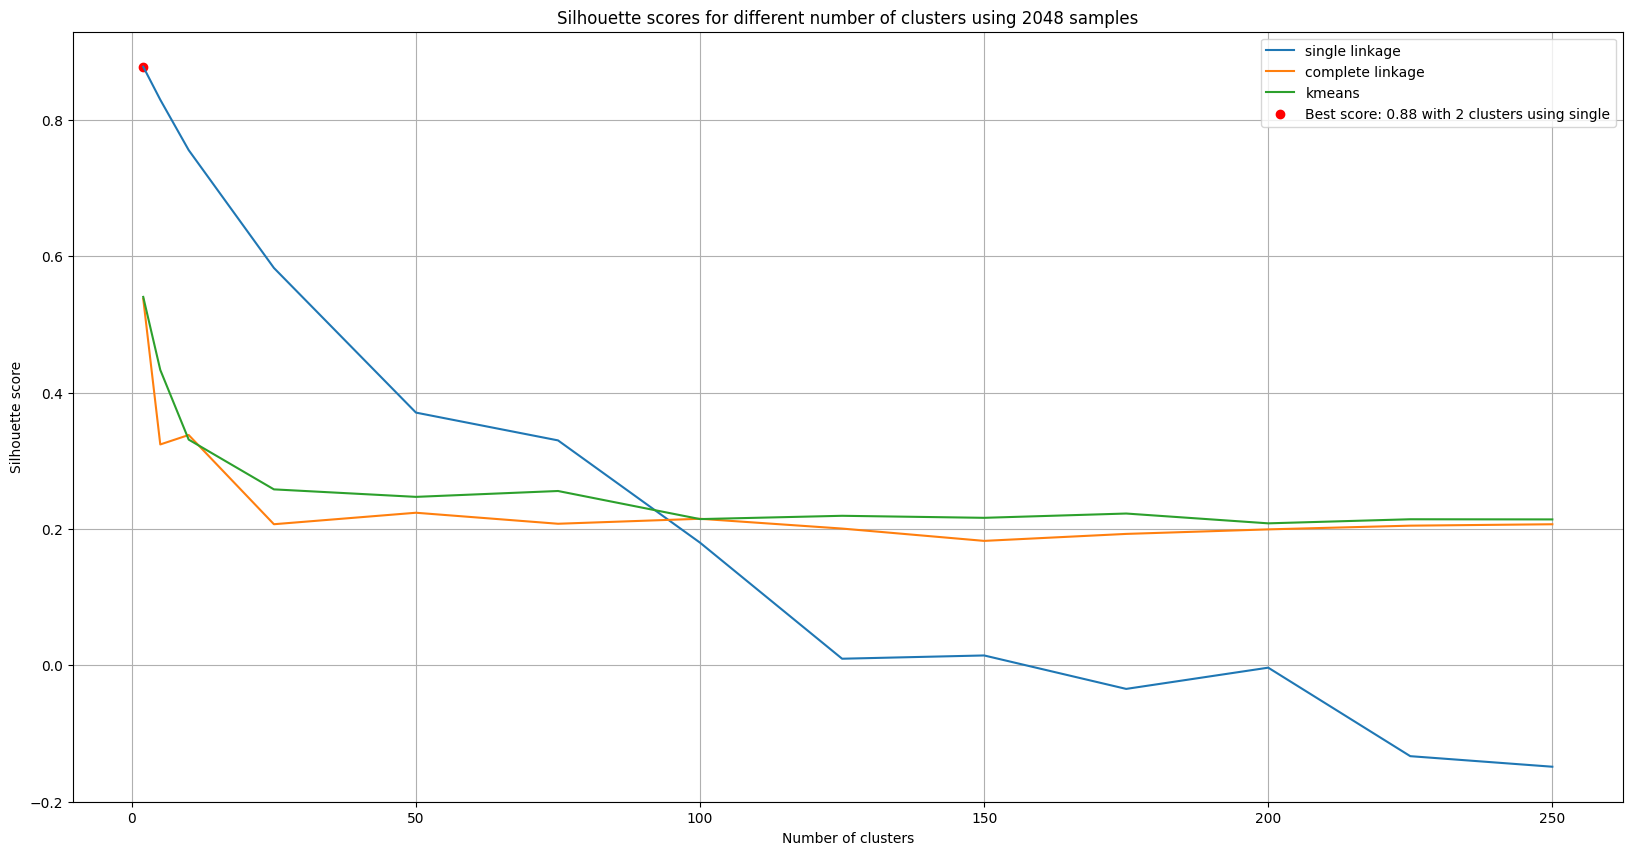

In [11]:
for n in silhouette_scores.keys():
    plt.figure(figsize=(20, 10))
    plt.title(f'Silhouette scores for different number of clusters using {n} samples')
    plt.plot(list(silhouette_scores[n].keys()), [v['single'] for v in silhouette_scores[n].values()], label='single linkage')
    plt.plot(list(silhouette_scores[n].keys()), [v['complete'] for v in silhouette_scores[n].values()], label='complete linkage')
    plt.plot(list(silhouette_scores[n].keys()), [v['kmeans'] for v in silhouette_scores[n].values()], label='kmeans')

    max_score = float('-inf')
    best_n_clusters = None
    best_algo = None
    for k,v in silhouette_scores[n].items():
        for algo, score in v.items():
            if score > max_score:
                max_score = score
                best_n_clusters = k
                best_algo = algo
                
    plt.scatter(best_n_clusters, max_score, color='red', label=f'Best score: {max_score:.2f} with {best_n_clusters} clusters using {best_algo}')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.legend()
    plt.grid()
    plt.savefig('silhouette_scores_'+str(n)+'.png')
    plt.show()

In [13]:
def get_data(path_to_csv, number_initial_samples, stats):
    chosen_indices = np.random.choice(number_lines, number_initial_samples, replace=False)
    i=-1
    data = {}
    headers = []

    for line in open(path_to_csv):
        if i == -1:
            headers = line.strip().split(',')[1:]
        elif i in chosen_indices:
            values = line.strip().split(',')[1:]
            for j,v in enumerate(values):
                if v == '':
                    values[j] = stats[headers[j]].get_mean()
                else:
                    values[j] = float(v)
            data[i] = values
        i += 1
    return data

def get_cure_clusters(data, number_clusters, number_reps, alpha):
    idxs = sorted(list(data.keys()))
    temp_data = [data[i] for i in idxs]
    clustering = cure(temp_data, number_clusters, number_reps, alpha)
    clustering.process()

    clusters = {}
    for i in range(number_clusters):
        clusters[i] = {'reps': clustering.get_representors()[i]}
        clusters[i]['points'] = [idxs[j] for j in clustering.get_clusters()[i]]

    return clusters

path_to_file = 'CC_GENERAL_CLEANED.csv'
stats = pickle.load(open('stats.pkl', 'rb'))
number_lines = sum(1 for _ in open(path_to_file)) - 1

number_initial_samples = 1024
num_clusters = 2
num_reps = 10
alpha = 0.2

data = get_data(path_to_file, number_initial_samples, stats)
clustering = get_cure_clusters(data, num_clusters, num_reps, alpha)


In [14]:
# save clustering
save_name = 'CURE_'+str(num_clusters)+'_'+str(num_reps)+'_'+str(alpha)+'.pkl'
with open(save_name, 'wb') as f:
    pickle.dump(clustering, f)

In [15]:
def get_closest_CURE_cluster(point, clusters):
    min_dist = float('inf')
    closest_cluster = None
    for cluster in clusters.keys():
        for rep in clusters[cluster]['reps']:
            dist = np.linalg.norm(np.array(point) - np.array(rep))
            if dist < min_dist:
                min_dist = dist
                closest_cluster = cluster
    return closest_cluster

path_to_file = 'CC_GENERAL_CLEANED.csv'

i=-1
idxs = list(data.keys())
stats = pickle.load(open('stats.pkl', 'rb'))
headers = []

for line in open(path_to_file):
    if i == -1:
        headers = line.strip().split(',')[1:]
    elif i not in idxs:
        values = line.strip().split(',')[1:]
        for j,v in enumerate(values):
            if v == '':
                values[j] = stats[headers[j]].get_mean()
            else:
                values[j] = float(v)
        closest_cluster = get_closest_CURE_cluster(values, clustering)
        clustering[closest_cluster]['points'].append(i)
    i += 1

In [16]:
for k,v in clustering.items():
    print(len(v['points']))

6269
3


In [17]:
save_name = 'FULL_CURE_'+str(num_clusters)+'_'+str(num_reps)+'_'+str(alpha)+'.pkl'
with open(save_name, 'wb') as f:
    pickle.dump(clustering, f)

## This is a problem! According to all clustering algorithms, CURE inclusive, the best silhouette value comes out of 2 clusters. But when we perform clustering we see that one cluster only contains 1 element. This element is probably an outlier. Therefore, before clustering we should use a n-dimensional metric to detect outliers like Mahalanobis Distance (MD). To calculate MD for each sample we need a covariance matrix of the data. Since we are using data analytics techniques and simulating a big dataset (big enough to not fit in memory), we need to calulate the covariance matrix using an estimator. If we sample 1000 elements from the dataset many times, and calculate the covariance matrix for these, we can average the sum of differences to the mean element wise to see if it is a good estimator. It turns out that for this dataset it is an excellent estimator, thus we can use an estimated covariance matrix for the MD calculations.

In [23]:
covariance_matrices = []

path_to_file = 'CC_GENERAL_CLEANED.csv'
number_lines = sum(1 for _ in open(path_to_file)) - 1
stats = pickle.load(open('stats.pkl', 'rb'))

for i in range(10):
    chosen_indices = np.random.choice(number_lines, 1000, replace=False)
    headers = []
    i=-1
    data = []
    for line in open(path_to_file):
            if i == -1:
                headers = line.strip().split(',')[1:]
            elif i in chosen_indices:
                values = line.strip().split(',')[1:]
                for j,v in enumerate(values):
                    if v == '':
                        values[j] = stats[headers[j]].get_mean()
                    else:
                        values[j] = float(v)
                data.append(values)
            i += 1
    data = np.array(data)
    covariance_matrix = np.cov(data.T)
    covariance_matrices.append(covariance_matrix)


mean_covariance_matrix = np.mean(covariance_matrices, axis=0)
mean_diff = 0
for cov in covariance_matrices:
    mean_diff += np.sum(cov - mean_covariance_matrix)
mean_diff /= len(covariance_matrices)
print(mean_diff)

-1.6763806343078614e-09


In [24]:
def mahalanobis_distance(point, mean_vector, covariance_matrix):
    return np.sqrt((point - mean_vector).T @ np.linalg.inv(covariance_matrix) @ (point - mean_vector))

path_to_file = 'CC_GENERAL_CLEANED.csv'
number_lines = sum(1 for _ in open(path_to_file)) - 1
stats = pickle.load(open('stats.pkl', 'rb'))
headers = []
i=-1
data = []
mean_vec = np.array([stats[header].get_mean() for header in stats.keys()])
mahalanobis_distances = {}

for line in open(path_to_file):
    if i == -1:
        headers = line.strip().split(',')[1:]
    else:
        values = line.strip().split(',')[1:]
        for j,v in enumerate(values):
            if v == '':
                values[j] = stats[headers[j]].get_mean()
            else:
                values[j] = float(v)
        values = np.array(values)
        mahalanobis_distances[i] = mahalanobis_distance(values, mean_vec, mean_covariance_matrix)
    i += 1

In [25]:
mean_mahalanobis = np.mean(list(mahalanobis_distances.values()))
std_mahalanobis = np.std(list(mahalanobis_distances.values()))
print(f'Mean: {mean_mahalanobis:.2f}, Std: {std_mahalanobis:.2f}')

Mean: 3.37, Std: 2.31


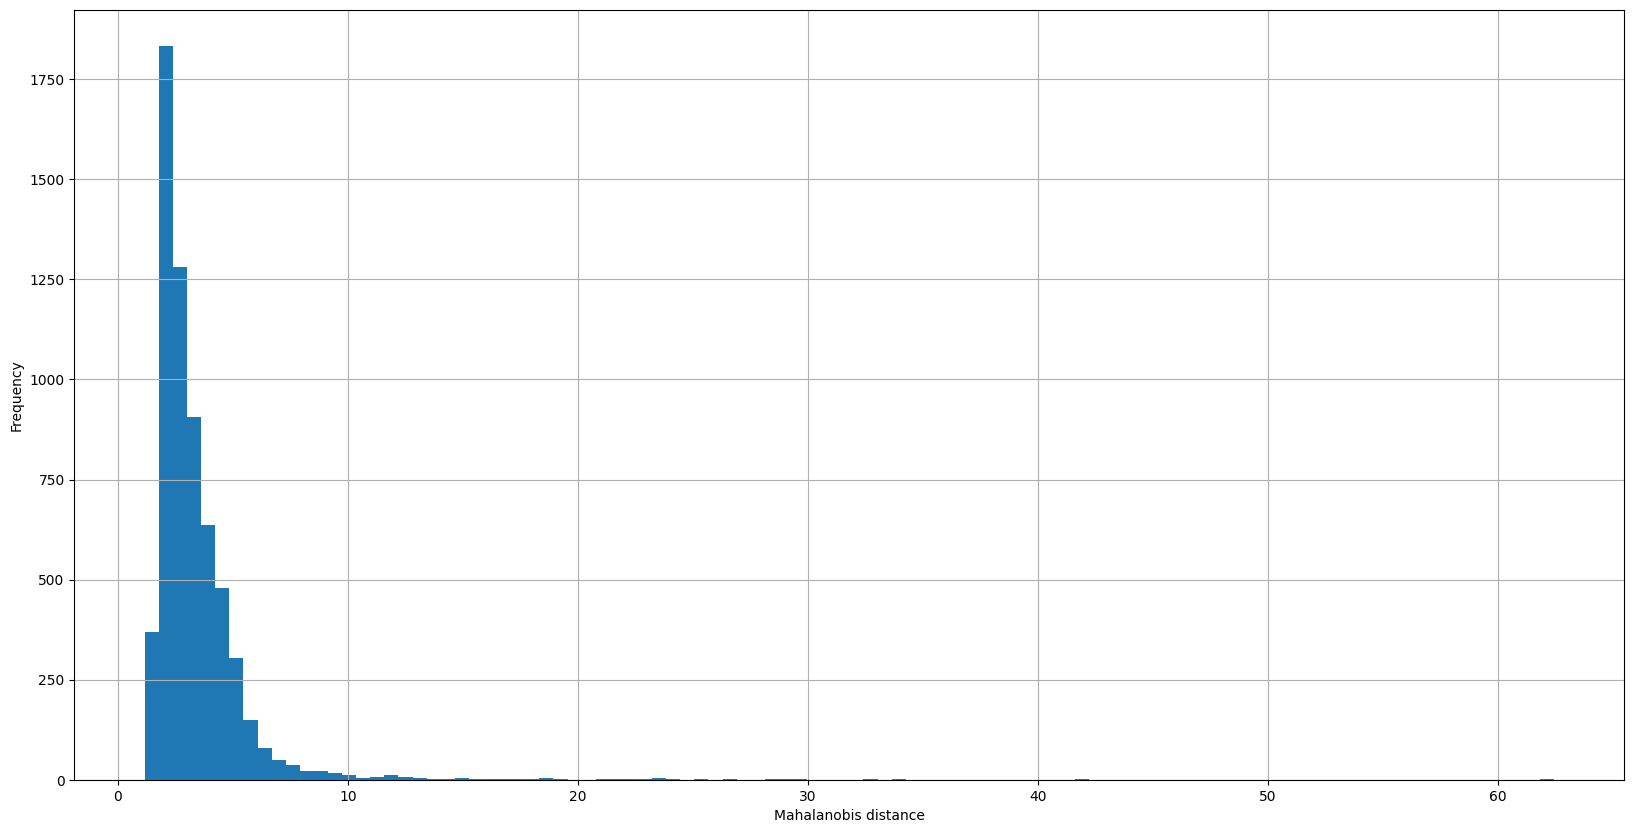

In [26]:
plt.figure(figsize=(20, 10))
plt.hist(list(mahalanobis_distances.values()), bins=100)
plt.xlabel('Mahalanobis distance')
plt.ylabel('Frequency')
plt.grid()

## According to the paper by Rousseeuw and Van Zomeren (1990), (https://imaging.mrc-cbu.cam.ac.uk/statswiki/FAQ/mahal?action=AttachFile&do=view&target=chisqoutlier.pdf), a good threshold to detect outliers can be the value of Chi Squared distribution with k degrees of freedom and probability 0.99, where k is the number of parameters such that threshold = X_2(k,0.99)

In [27]:
threshold = chi2.ppf(0.99, 13)
print(f'Threshold: {threshold:.2f}')
outliers = [k for k,v in mahalanobis_distances.items() if v > threshold]
print(f'Number of outliers: {len(outliers)}')
print(f'Outliers: {outliers}')
print(clustering[1]['points'])

Threshold: 27.69
Number of outliers: 8
Outliers: [82, 334, 367, 1489, 3695, 3719, 4807, 6204]
[334, 367, 1110]


In [28]:
# sanity check
all = []
for k,v in clustering.items():
    all = all + v['points']
print(len(all))

6272


## next thing to do is rule out outliers and recompute clustering analysis and clustering itself

In [29]:
# write all lines to a file exept the outliers
i=-1
with open('CC_GENERAL_CLEANED_NO_OUTLIERS.csv', 'w') as f:
    for line in open('CC_GENERAL_CLEANED.csv'):
        if i not in outliers:
            f.write(line)
        i += 1

In [30]:
path_to_file = 'CC_GENERAL_CLEANED_NO_OUTLIERS.csv'
number_lines = sum(1 for _ in open(path_to_file)) - 1

number_initial_samples = [2**i for i in range(8,int(np.log2(number_lines)))]
num_clusters = [2,5,10] + [i for i in range(25, 251, 25)]
silhouette_scores = {}

for n in tqdm(number_initial_samples):

    chosen_indices = np.random.choice(number_lines, n, replace=False)
    i=-1
    data = []
    headers = []

    for line in open(path_to_file):
        if i == -1:
            headers = line.strip().split(',')[1:]
        elif i in chosen_indices:
            values = line.strip().split(',')[1:]
            for j,v in enumerate(values):
                if v == '':
                    values[j] = stats[headers[j]].get_mean()
                else:
                    values[j] = float(v)
            data.append(values)
        i += 1

    data = np.array(data)
    silhouette_scores[n] = {}

    for n_clusters in tqdm(num_clusters):
        silhouette_scores[n][n_clusters] = {}
        clustering = AgglomerativeClustering(n_clusters=n_clusters).fit_predict(data)
        silhouette_scores[n][n_clusters]['complete'] = silhouette_score(data, clustering)
        clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='single').fit_predict(data)
        silhouette_scores[n][n_clusters]['single'] = silhouette_score(data, clustering)
        clustering = KMeans(n_clusters=n_clusters).fit_predict(data)
        silhouette_scores[n][n_clusters]['kmeans'] = silhouette_score(data, clustering)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [24]:
with open('silhouette_scores_no_outliers.pkl', 'wb') as f:
    pickle.dump(silhouette_scores, f)

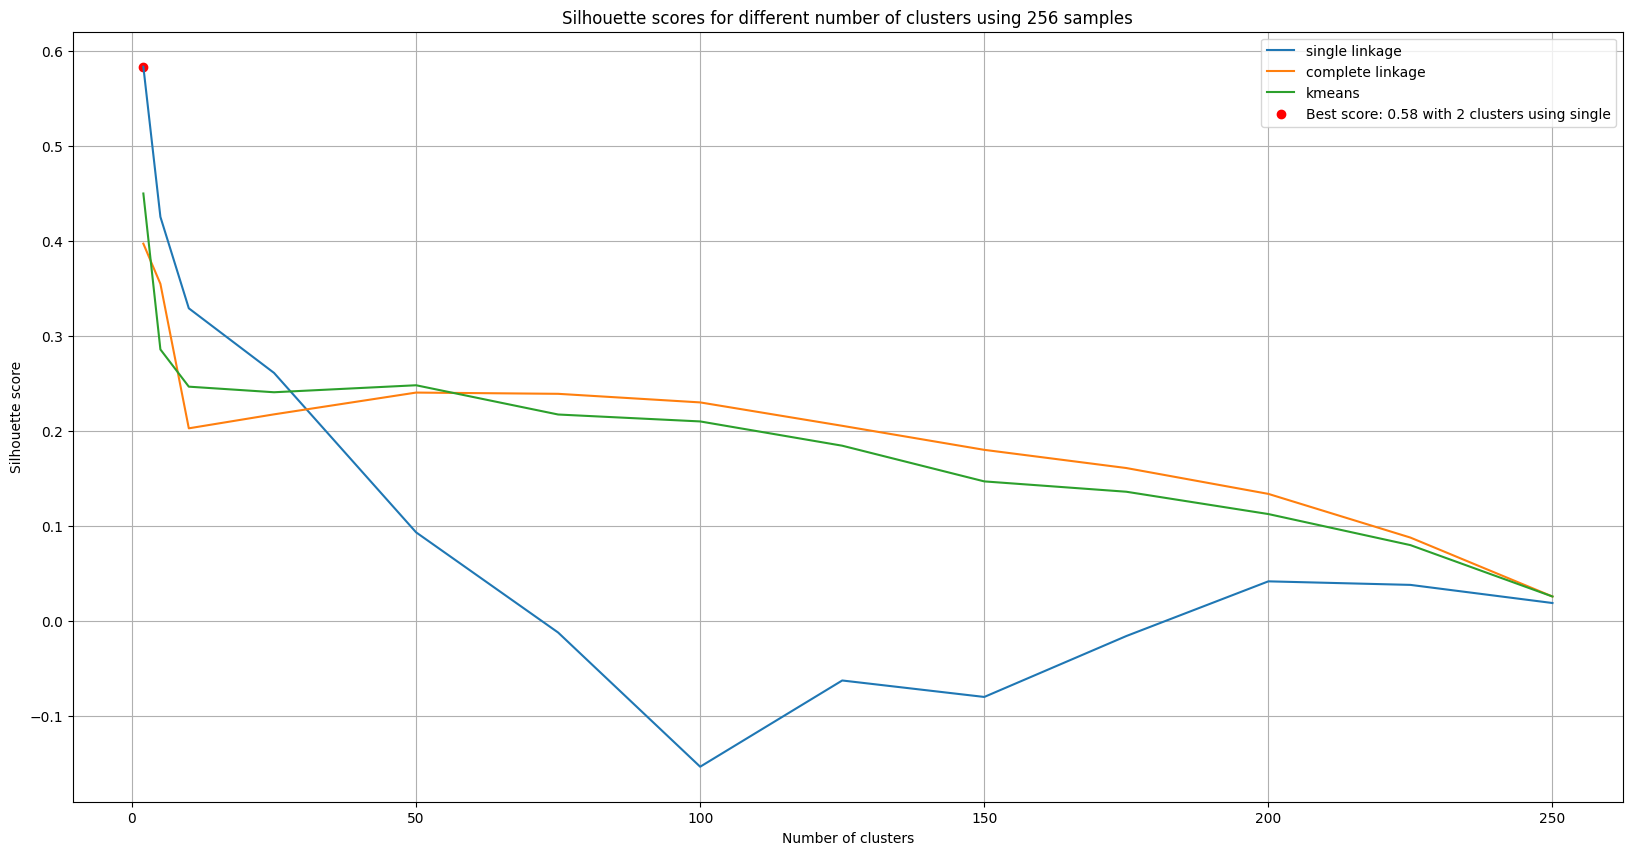

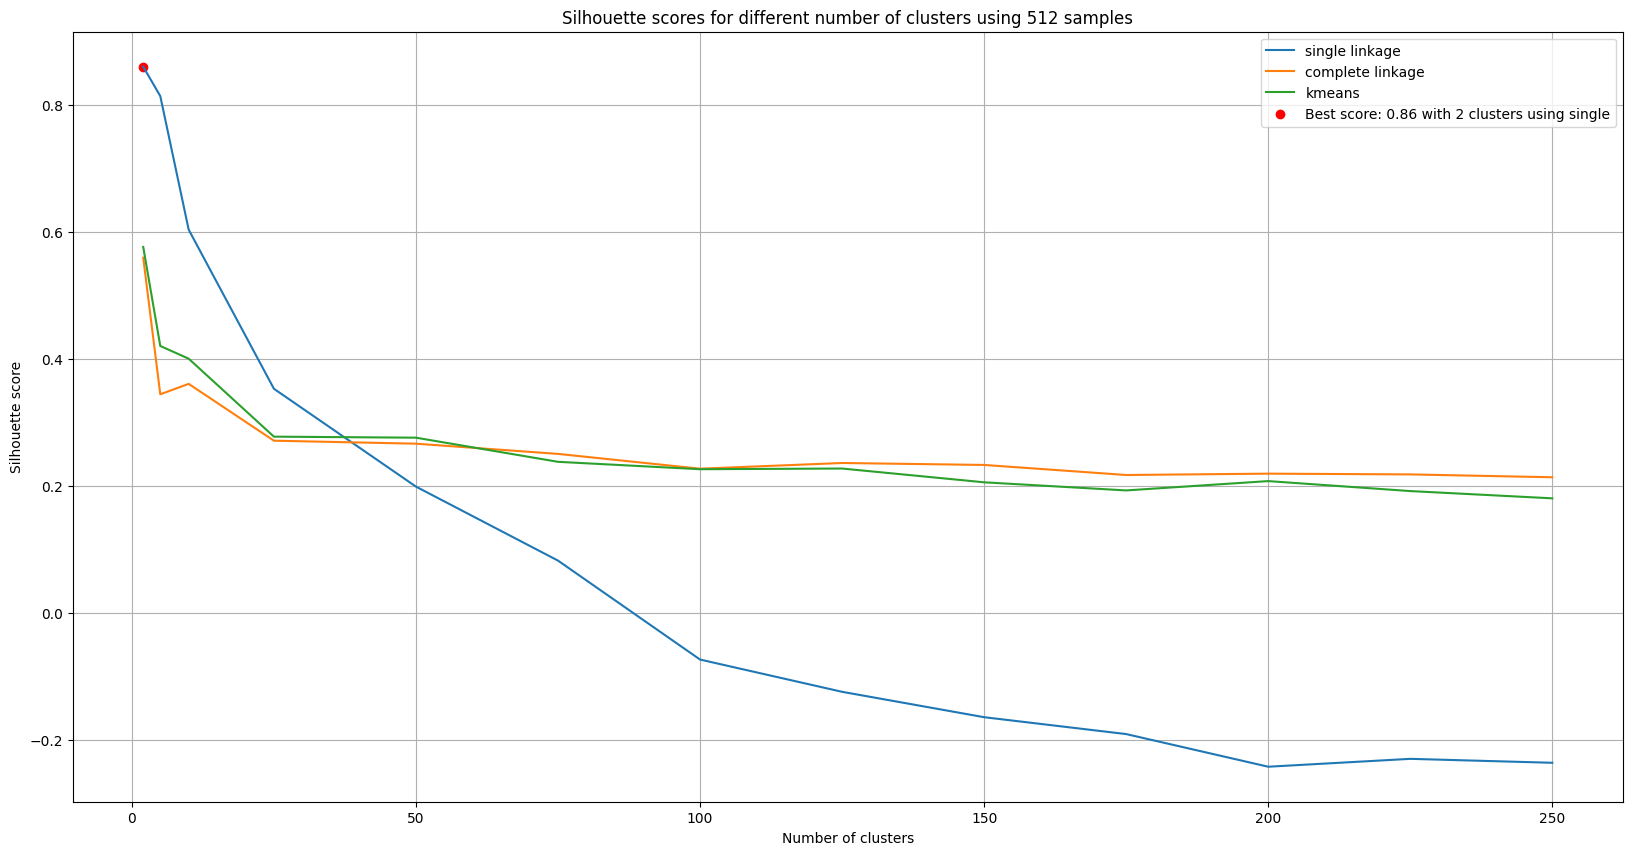

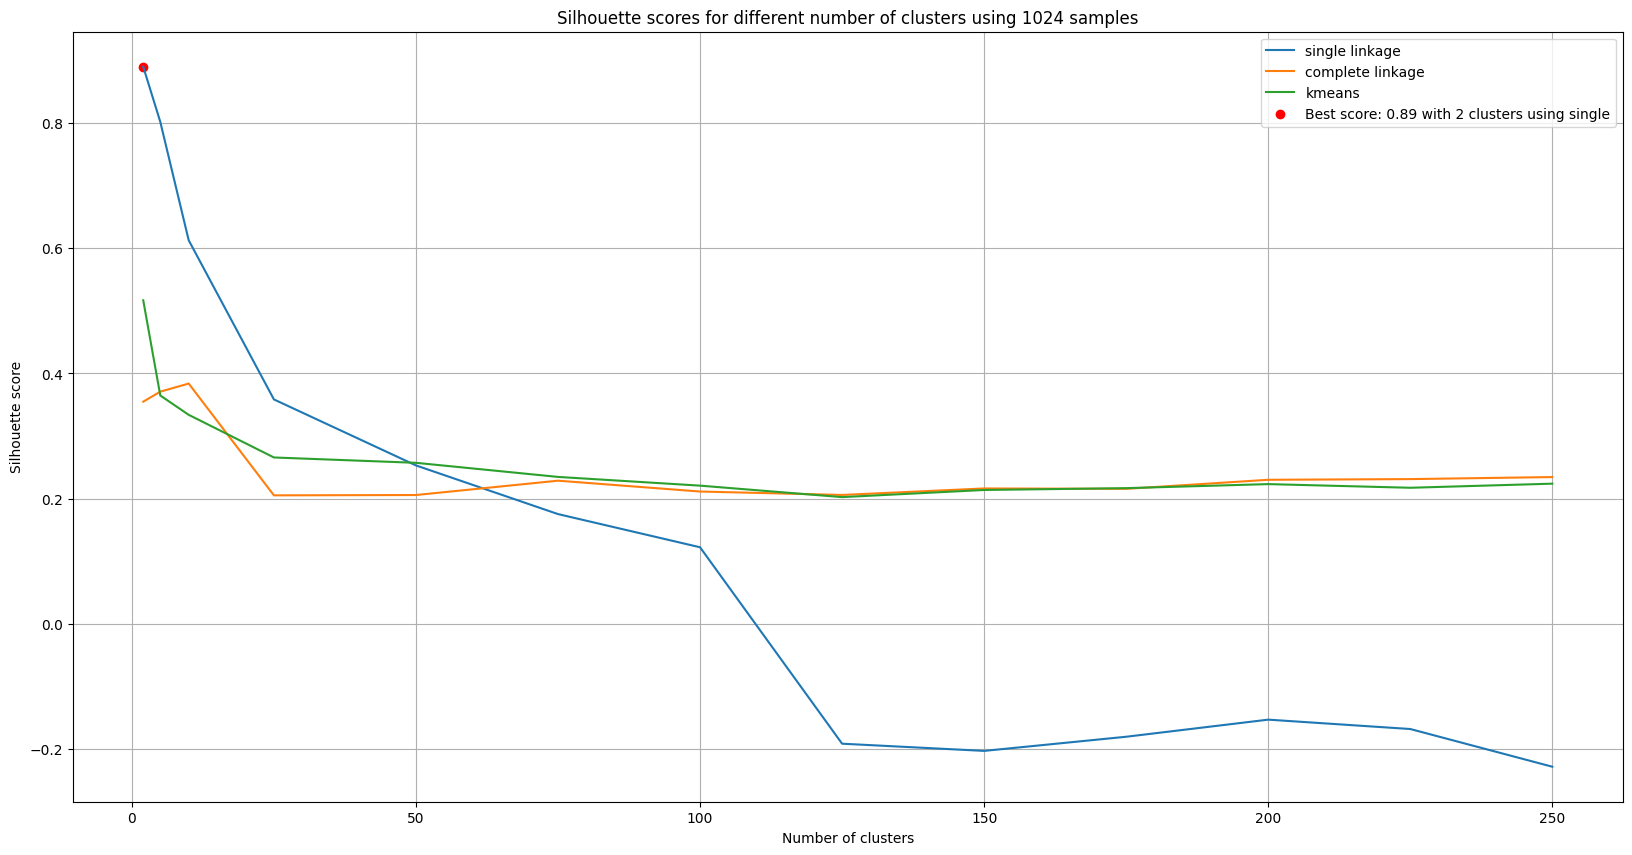

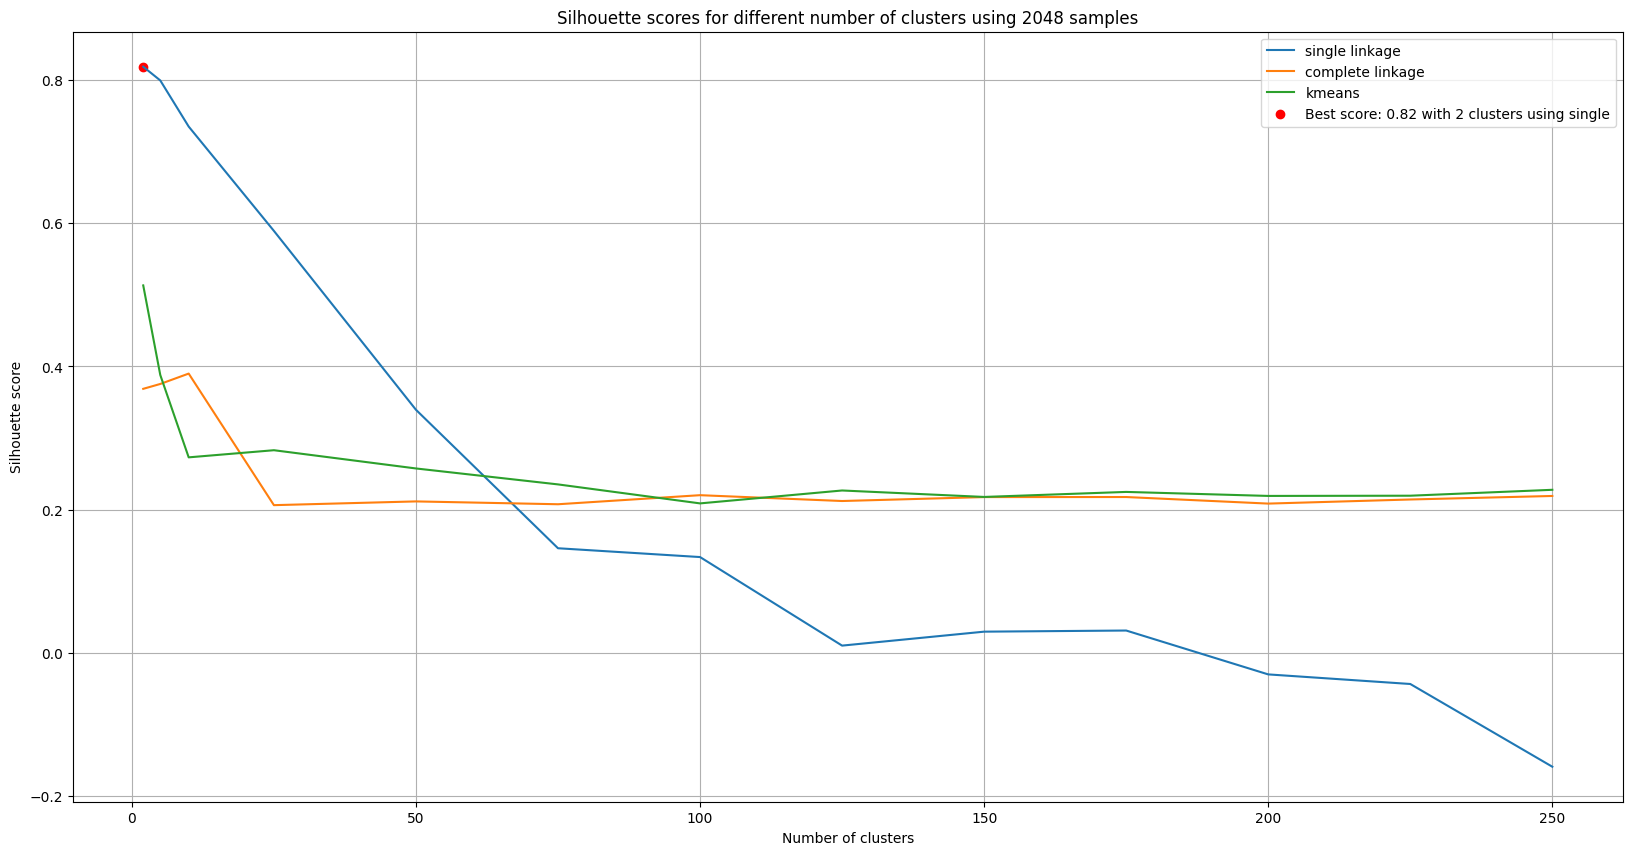

In [31]:
for n in silhouette_scores.keys():
    plt.figure(figsize=(20, 10))
    plt.title(f'Silhouette scores for different number of clusters using {n} samples')
    plt.plot(list(silhouette_scores[n].keys()), [v['single'] for v in silhouette_scores[n].values()], label='single linkage')
    plt.plot(list(silhouette_scores[n].keys()), [v['complete'] for v in silhouette_scores[n].values()], label='complete linkage')
    plt.plot(list(silhouette_scores[n].keys()), [v['kmeans'] for v in silhouette_scores[n].values()], label='kmeans')

    max_score = float('-inf')
    best_n_clusters = None
    best_algo = None
    for k,v in silhouette_scores[n].items():
        for algo, score in v.items():
            if score > max_score:
                max_score = score
                best_n_clusters = k
                best_algo = algo
                
    plt.scatter(best_n_clusters, max_score, color='red', label=f'Best score: {max_score:.2f} with {best_n_clusters} clusters using {best_algo}')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.legend()
    plt.grid()
    plt.savefig('silhouette_scores_'+str(n)+'.png')
    plt.show()

In [41]:
def get_data(path_to_csv, number_initial_samples, stats):
    chosen_indices = np.random.choice(number_lines, number_initial_samples, replace=False)
    i=-1
    data = {}
    headers = []

    for line in open(path_to_csv):
        if i == -1:
            headers = line.strip().split(',')[1:]
        elif i in chosen_indices:
            values = line.strip().split(',')[1:]
            for j,v in enumerate(values):
                if v == '':
                    values[j] = stats[headers[j]].get_mean()
                else:
                    values[j] = float(v)
            data[i] = values
        i += 1
    return data

def get_cure_clusters(data, number_clusters, number_reps, alpha):
    idxs = sorted(list(data.keys()))
    temp_data = [data[i] for i in idxs]
    clustering = cure(temp_data, number_clusters, number_reps, alpha)
    clustering.process()

    clusters = {}
    for i in range(number_clusters):
        clusters[i] = {'reps': clustering.get_representors()[i]}
        clusters[i]['points'] = [idxs[j] for j in clustering.get_clusters()[i]]

    return clusters

class ColumnStatistics:
    def __init__(self, name):
        self.name = name
        self.N = 0
        self.sum = 0
        self.sum2 = 0
    
    def get_mean(self):
        return self.sum / self.N
    
    def get_std(self):
        return np.sqrt(self.sum2 / self.N - (self.sum / self.N) ** 2)
    
    def get_N(self):
        return self.N

path_to_file = 'CC_GENERAL_CLEANED_NO_OUTLIERS.csv'
stats = pickle.load(open('stats.pkl', 'rb'))
number_lines = sum(1 for _ in open(path_to_file)) - 1

number_initial_samples = 1024
num_clusters = 2
num_reps = 10
alpha = 0.5

data = get_data(path_to_file, number_initial_samples, stats)
clustering = get_cure_clusters(data, num_clusters, num_reps, alpha)


In [42]:
# save clustering
save_name = 'CURE_'+str(num_clusters)+'_'+str(num_reps)+'_'+str(alpha)+'_no_outliers.pkl'
with open(save_name, 'wb') as f:
    pickle.dump(clustering, f)

In [43]:
def get_closest_CURE_cluster(point, clusters):
    min_dist = float('inf')
    closest_cluster = None
    for cluster in clusters.keys():
        for rep in clusters[cluster]['reps']:
            dist = np.linalg.norm(np.array(point) - np.array(rep))
            if dist < min_dist:
                min_dist = dist
                closest_cluster = cluster
    return closest_cluster

path_to_file = 'CC_GENERAL_CLEANED_NO_OUTLIERS.csv'

i=-1
idxs = list(data.keys())
stats = pickle.load(open('stats.pkl', 'rb'))
headers = []

for line in open(path_to_file):
    if i == -1:
        headers = line.strip().split(',')[1:]
    elif i not in idxs:
        values = line.strip().split(',')[1:]
        for j,v in enumerate(values):
            if v == '':
                values[j] = stats[headers[j]].get_mean()
            else:
                values[j] = float(v)
        closest_cluster = get_closest_CURE_cluster(values, clustering)
        clustering[closest_cluster]['points'].append(i)
    i += 1

In [44]:
for k,v in clustering.items():
    print(len(v['points']))

20
6244


In [45]:
save_name = 'FULL_CURE_'+str(num_clusters)+'_'+str(num_reps)+'_'+str(alpha)+'_no_outliers.pkl'
with open(save_name, 'wb') as f:
    pickle.dump(clustering, f)

In [54]:


from sklearn.cluster import KMeans, AgglomerativeClustering
import pandas as pd
import sys

path_to_file = 'CC_GENERAL_CLEANED_NO_OUTLIERS.csv'
df = pd.read_csv(path_to_file)

kmeans = KMeans(n_clusters=2).fit_predict(df.values)
agglo_complete = AgglomerativeClustering(n_clusters=2).fit_predict(df.values)
agglo_single = AgglomerativeClustering(n_clusters=2, linkage='single').fit_predict(df.values)

df['kmeans'] = kmeans
df['agglo_complete'] = agglo_complete
df['agglo_single'] = agglo_single

print(df['kmeans'].value_counts())
print(df['agglo_complete'].value_counts())
print(df['agglo_single'].value_counts())

print(f'kmeans silhouette score: {silhouette_score(df.values, kmeans):.2f}')
print(f'agglo complete silhouette score: {silhouette_score(df.values, agglo_complete):.2f}')
print(f'agglo single silhouette score: {silhouette_score(df.values, agglo_single):.2f}')

kmeans
1    5010
0    1254
Name: count, dtype: int64
agglo_complete
1    3453
0    2811
Name: count, dtype: int64
agglo_single
0    6263
1       1
Name: count, dtype: int64
kmeans silhouette score: 0.52
agglo complete silhouette score: 0.35
agglo single silhouette score: 0.87


# OLD STUFF (ignore)

In [ ]:
def get_data(path_to_csv, number_initial_samples, stats):
    chosen_indices = np.random.choice(number_lines, number_initial_samples, replace=False)
    i=-1
    data = []
    headers = []

    for line in open(path_to_csv):
        if i == -1:
            headers = line.strip().split(',')[1:]
        elif i in chosen_indices:
            values = line.strip().split(',')[1:]
            for j,v in enumerate(values):
                if v == '':
                    values[j] = stats[headers[j]].get_mean()
                else:
                    values[j] = float(v)
            data.append(values)
        i += 1
    return data

def get_cure_clusters(data, number_clusters, number_reps, alpha):
    clustering = cure(data, number_clusters, number_reps, alpha)
    clustering.process()

    clusters = {}
    for i in range(len(clustering.get_representors())):
        clusters[i] = {'reps': clustering.get_representors()[i]}
        clusters[i]['points'] = [j for j in clustering.get_clusters()[i]]

    return clusters

def get_silhouette(clusters, data):
    labels = np.zeros(data.shape[0])
    for k,v in clusters.items():
        for point in v['points']:
            labels[point] = k
    return silhouette_score(data, labels)


path_to_csv = 'CC_GENERAL_CLEANED.csv'
num_initial_samples = [512,1024,2048]
num_reps = 10
alpha = 0.2
results = {}
number_lines = sum(1 for _ in open(path_to_csv)) - 1
num_clusters = [2**i for i in range(1,9)]


for n_samples in tqdm(num_initial_samples):
    results[n_samples] = {}
    data = get_data(path_to_csv, n_samples, stats)
    for n_clusters in tqdm(num_clusters):
        results[n_samples][n_clusters] = {}
        clusters = get_cure_clusters(data, n_clusters, num_reps, 0.2)
        score = get_silhouette(clusters, np.array(data))
        results[n_samples][n_clusters] = score        

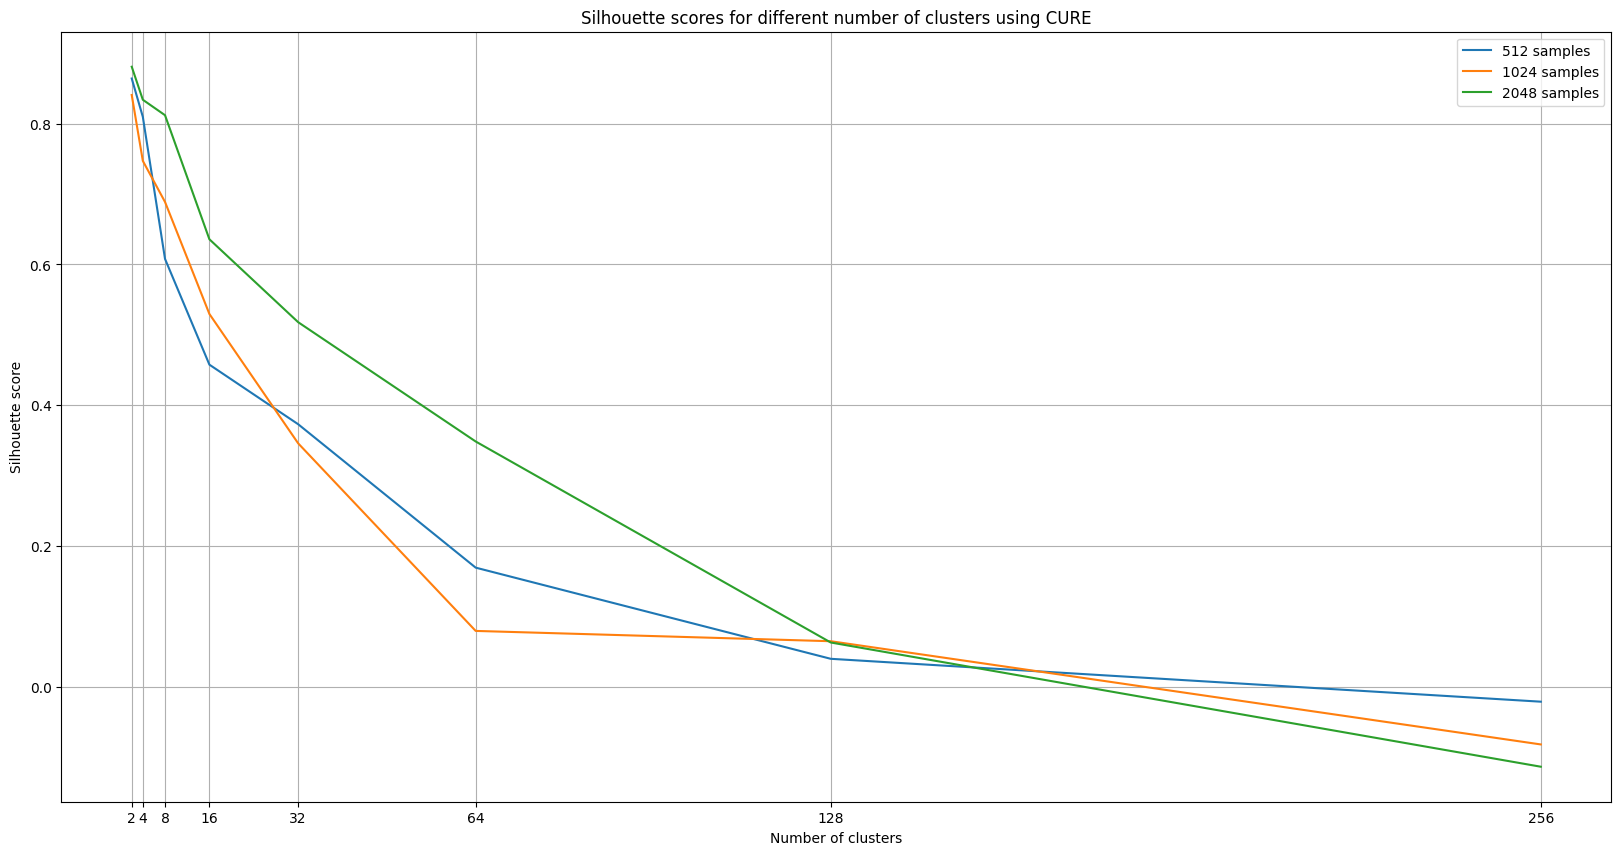

In [28]:
plt.figure(figsize=(20, 10))
plt.title('Silhouette scores for different number of clusters using CURE')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')

for n_samples in results.keys():
    plt.plot(results[n_samples].keys(), results[n_samples].values(), label=f'{n_samples} samples')

# set x ticks to be num_clusters
plt.xticks(num_clusters)
plt.legend()
plt.grid()
plt.show()

In [104]:
from pyclustering.cluster.cure import cure

path_to_file = './CC GENERAL.csv'
number_initial_samples = 2000
number_lines = sum(1 for _ in open(path_to_file)) - 1
chosen_indices = np.random.choice(number_lines, number_initial_samples, replace=False)
i=-1
data = []
headers = []

for line in open(path_to_file):
    if i == -1:
        headers = line.strip().split(',')[1:]
    elif i in chosen_indices:
        values = line.strip().split(',')[1:]
        for j,v in enumerate(values):
            if v == '':
                values[j] = stats[headers[j]].get_mean()
            else:
                values[j] = float(v)
        data.append(values)
    i += 1


number_representatives = 5
num_cluters = 2
alpha = 0.2 

clustering = cure(data, num_cluters, number_representatives, alpha)
clustering.process()

In [105]:
clusters = {}
for i in range(len(clustering.get_representors())):
    clusters[i] = {'reps': clustering.get_representors()[i]}
    clusters[i]['points'] = [chosen_indices[j] for j in clustering.get_clusters()[i]]

In [106]:
sanity_check = []
for k,v in clusters.items():
    for idx in v['points']:
        sanity_check.append(idx)

for idx in sanity_check:
    if idx not in chosen_indices:
        print('Error')

for idx in chosen_indices:
    if idx not in sanity_check:
        print('Error')

In [107]:
def get_closest_representative(point, clusters, max_distance_threshold=None):
    min_distance = float('inf')
    closest_cluster = None
    for k,v in clusters.items():
        for rep in v['reps']:
            distance = np.linalg.norm(np.array(point) - np.array(rep))
            A = distance < min_distance
            C = max_distance_threshold is None
            B = distance < max_distance_threshold if not C else False
            if A and (C or B):
                min_distance = distance
                closest_cluster = k
    return closest_cluster, min_distance

i=-1
distances = []

for line in open(path_to_file):
    if i != -1 and i not in chosen_indices:
        point = line.strip().split(',')[1:]
        for j,v in enumerate(values):
            if v == '':
                point[j] = stats[headers[j]].get_mean()
            else:
                point[j] = float(v)
        c,d = get_closest_representative(point, clusters)
        distances.append(d)
        clusters[c]['points'].append(i)
    i += 1

In [110]:
distances

[14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,
 14382.46061169379,


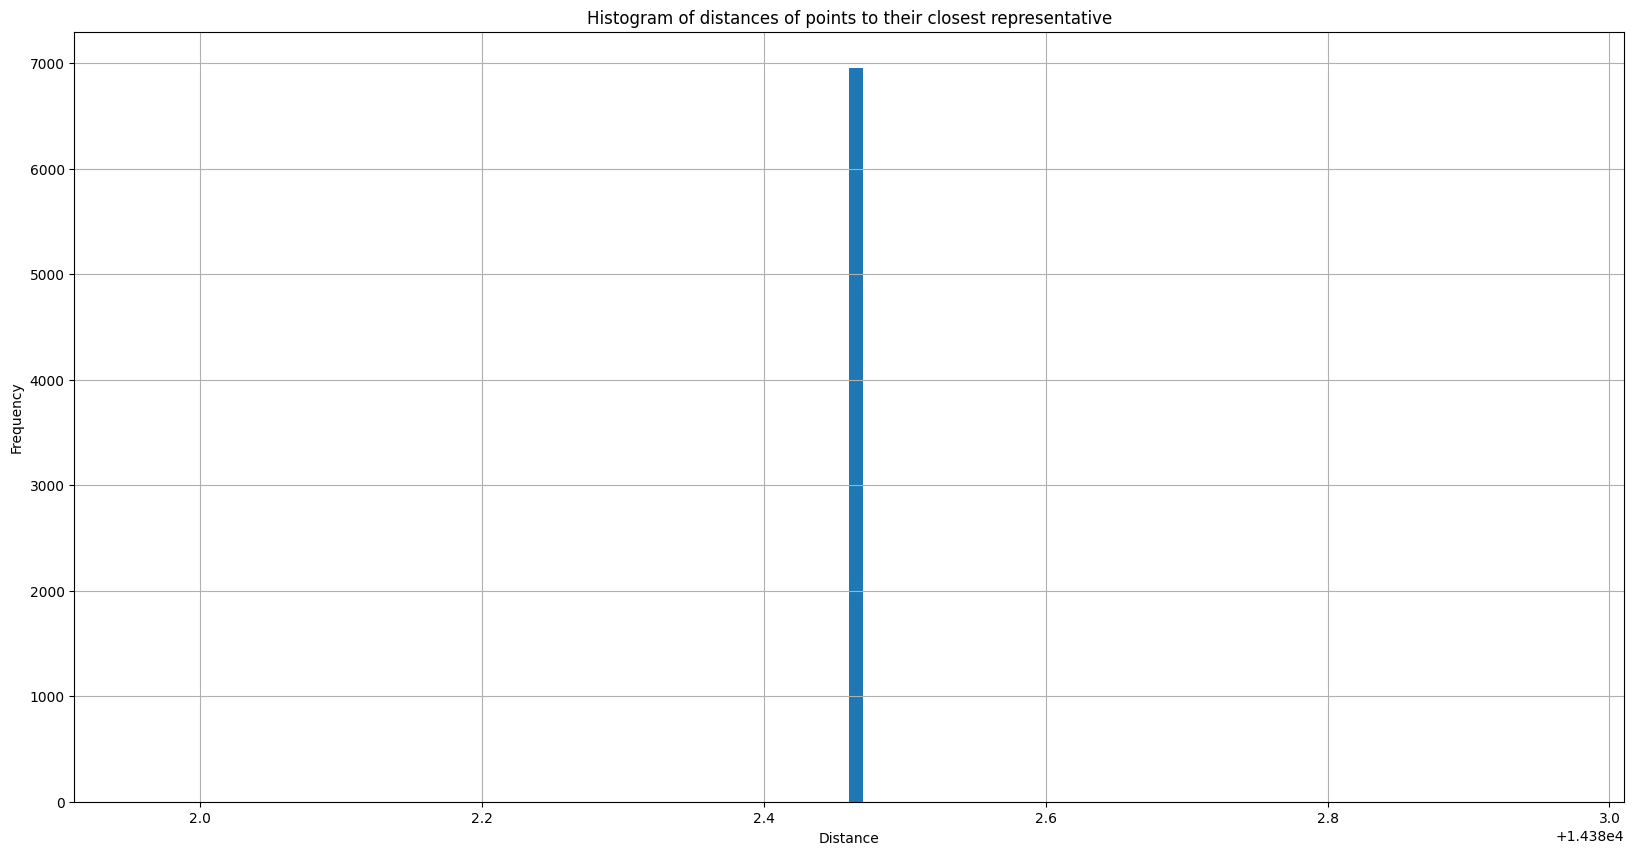

In [108]:
#plot hitogram of distances
plt.figure(figsize=(20, 10))
plt.hist(distances, bins=100)
plt.title('Histogram of distances of points to their closest representative')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid()
plt.show()


In [96]:
clusters['info'] = {
    'num_clusters': num_cluters,
    'num_representatives': number_representatives,
    'alpha': alpha,
    'max_distance_threshold': None,
}

save_name = 'CURE_' + str(num_cluters) + '_' + str(number_representatives) + '_' + str(alpha) + '.pkl'
with open(save_name, 'wb') as f:
    pickle.dump(clusters, f)

In [10]:
# CURE algorithm
'''
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))


class CureCluster():
    def __init__(self, points, k_representatives, alpha):
        self.points = points
        self.alpha = alpha
        self.k = k_representatives       
        self.representatives = None
        self.centroid = None

    def set_k_representatives(self, k):
        num_points = len(self.points)
        if k >= num_points:
            self.representatives = self.points
            return

        distance_matrix = np.zeros((num_points, num_points))
        for i in range(num_points):
            for j in range(i,num_points):
                d = euclidean_distance(self.points[i], self.points[j])
                distance_matrix[i][j] = d
                distance_matrix[j][i] = d
        print('done')

        k_indices = list(combinations(range(len(self.points)), k))
        min_sum_distances = float('-inf')
        best_representatives = None
        for indices in tqdm(k_indices):
            sum_distances = 0
            for i in range(len(indices)):
                for j in range(i,len(indices)):
                    sum_distances += distance_matrix[indices[i]][indices[j]]
            if sum_distances > min_sum_distances:
                min_sum_distances = sum_distances
                best_representatives = indices
        self.representatives = [self.points[i] for i in best_representatives]

        self.compute_centroid()
        self.move_representatives_closer()

    def compute_centroid(self):
        self.centroid = np.mean(self.representatives, axis=0)
        return self.centroid
    
    def move_representatives_closer(self):
        for i in range(len(self.representatives)):
            self.representatives[i] = self.representatives[i] + self.alpha * (self.centroid - self.representatives[i])

def merge_clusters(cluster1, cluster2):
    new_points = cluster1.points + cluster2.points
    return CureCluster(new_points, cluster1.k, cluster1.alpha)

def is_cluster_close(cluster1, cluster2, threshold):
    for r1 in cluster1.representatives:
        for r2 in cluster2.representatives:
            if euclidean_distance(r1, r2) < threshold:
                return True
    return False
'''

In [58]:
# CURE algorithm
import math


def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))


class CureCluster():
    def __init__(self, points, k_representatives, alpha, search_comb_cap=3000000):
        self.points = points
        self.alpha = alpha
        self.k = k_representatives       
        self.representatives = None
        self.centroid = None
        self.search_comb_cap = search_comb_cap

    def set_k_representatives(self, k):
        if k >= len(self.points):
            self.representatives = self.points
            return
        
        distance_matrix = np.zeros((len(self.points), len(self.points)))
        number_combs = math.comb(len(self.points), k)

        current_points = None
        current_sum = float('-inf')
        if number_combs > self.search_comb_cap:
            tries = 0
            while tries < self.search_comb_cap:
                p = np.random.choice(len(self.points), k, replace=False)
                sum_distances = 0
                for i in range(k):
                    for j in range(i,k):
                        if distance_matrix[p[i]][p[j]] == 0:
                            distance_matrix[p[i]][p[j]] = euclidean_distance(self.points[p[i]], self.points[p[j]])
                        sum_distances += distance_matrix[p[i]][p[j]]
                if sum_distances > current_sum:
                    current_sum = sum_distances
                    current_points = p
                    tries = 0
                else:
                    tries += 1
        else:
            for combs in combinations(range(len(self.points)), k):
                sum_distances = 0
                for i in range(k):
                    for j in range(i,k):
                        if distance_matrix[combs[i]][combs[j]] == 0:
                            distance_matrix[combs[i]][combs[j]] = euclidean_distance(self.points[combs[i]], self.points[combs[j]])
                        sum_distances += distance_matrix[combs[i]][combs[j]]
                if sum_distances > current_sum:
                    current_sum = sum_distances
                    current_points = combs

        self.representatives = [self.points[i] for i in current_points]

        self.compute_centroid()
        self.move_representatives_closer()

    def compute_centroid(self):
        self.centroid = np.mean(self.representatives, axis=0)
        return self.centroid
    
    def move_representatives_closer(self):
        for i in range(len(self.representatives)):
            self.representatives[i] = self.representatives[i] + self.alpha * (self.centroid - self.representatives[i])

def merge_clusters(cluster1, cluster2):
    new_points = np.concatenate((cluster1.points, cluster2.points), axis=0)
    return CureCluster(new_points, cluster1.k, cluster1.alpha)

def is_cluster_close(cluster1, cluster2, threshold):
    for r1 in cluster1.representatives:
        for r2 in cluster2.representatives:
            if euclidean_distance(r1, r2) < threshold:
                return True
    return False


In [62]:
path_to_file = './CC GENERAL.csv'
number_initial_samples = 250
number_lines = sum(1 for _ in open(path_to_file)) - 1
chosen_indices = np.random.choice(number_lines, number_initial_samples, replace=False)
i=-1
data = []
headers = []

for line in open(path_to_file):
    if i == -1:
        headers = line.strip().split(',')[1:]
    elif i in chosen_indices:
        values = line.strip().split(',')[1:]
        for j,v in enumerate(values):
            if v == '':
                values[j] = stats[headers[j]].get_mean()
            else:
                values[j] = float(v)
        data.append(values)
    i += 1

data = np.array(data)

number_representatives = 5
num_initial_cluters = 20
clusters = {}
alpha = 0.2 

clustering = AgglomerativeClustering(n_clusters=num_initial_cluters).fit_predict(data)
for i in range(num_initial_cluters):
    clusters[i] = CureCluster(data[clustering == i], number_representatives, alpha)



In [63]:
with open('clusters_initial.pkl', 'wb') as f:
    pickle.dump(clusters, f)

with open('clusters_initial.pkl', 'rb') as f:
    clusters = pickle.load(f)

max_cluster = -1,-1
for i in range(num_initial_cluters):
    print(len(clusters[i].points))
    if len(clusters[i].points) > max_cluster[1]:
        max_cluster = i, len(clusters[i].points)
print(max_cluster)

48
6
97
6
3
8
14
3
8
2
1
1
10
11
26
1
2
1
1
1
(2, 97)


In [64]:
for i in range(len(clusters)):
    clusters[i].set_k_representatives(number_representatives)

In [65]:
with open('clusters_initial_with_reps.pkl', 'wb') as f:
   pickle.dump(clusters, f)

with open('clusters_initial_with_reps.pkl', 'rb') as f:
      clusters = pickle.load(f)

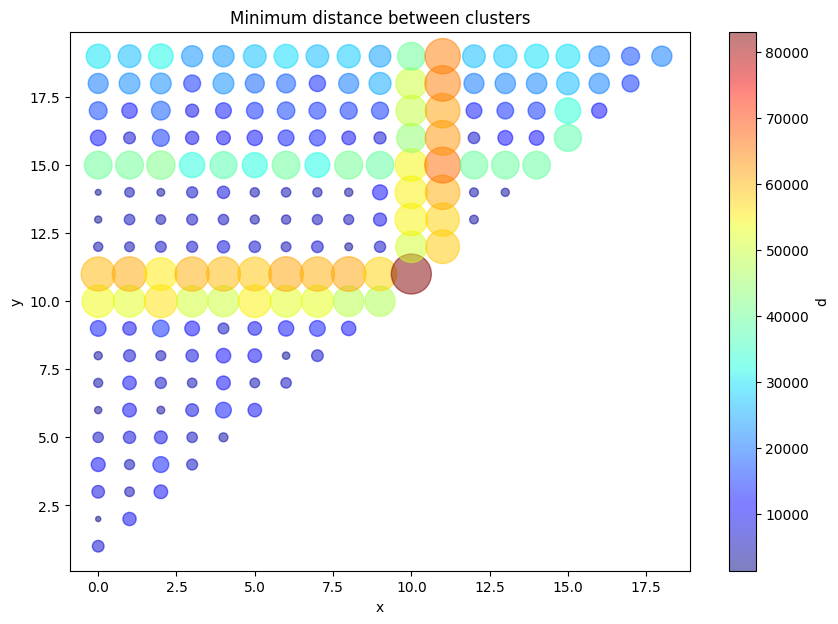

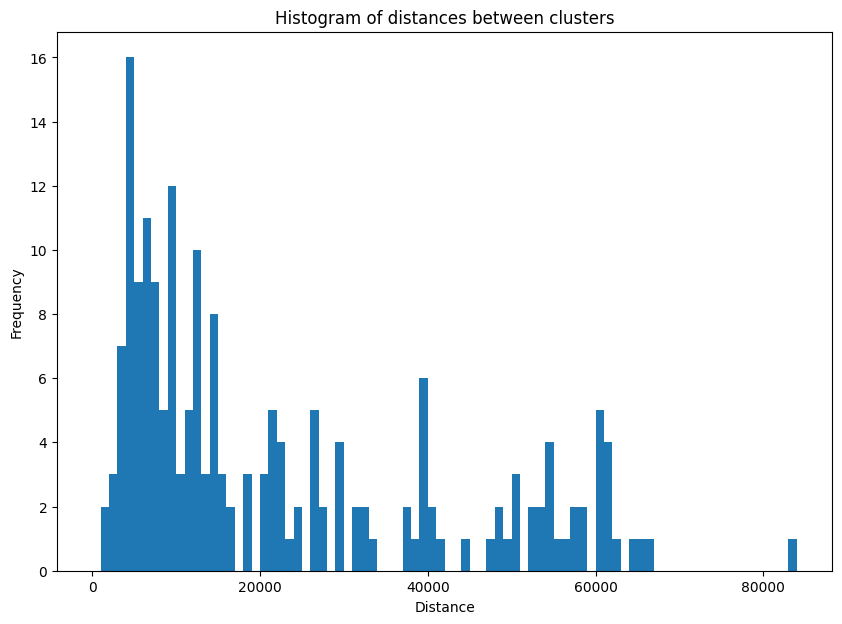

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


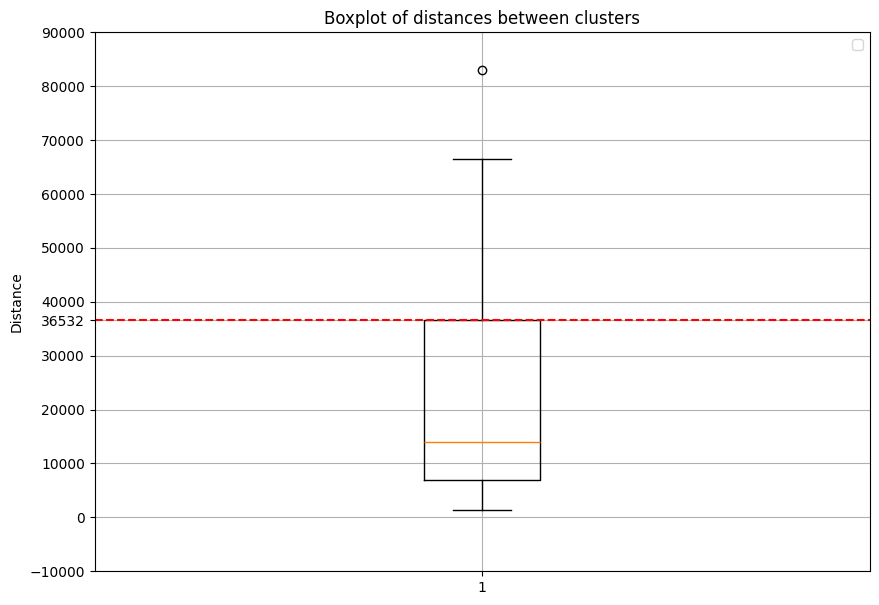

Mean: 22550.33
Std: 19572.67
Silhouette score: 0.2778


In [75]:
def show_cluster_info(clusters):
    min_distances = []
    num_initial_cluters = len(clusters)
    keys = list(clusters.keys())
    for i in range(len(keys)):
        for j in range(i+1, len(keys)):
            min_distance = float('inf')
            for r1 in clusters[keys[i]].representatives:
                for r2 in clusters[keys[j]].representatives:
                    d = euclidean_distance(r1, r2)
                    if d < min_distance:
                        min_distance = d
            min_distances.append((i,j,round(min_distance,2)))

    df_min_distances = pd.DataFrame(min_distances, columns=['x', 'y', 'd'])
    df_min_distances.plot(kind='scatter', x='x', y='y', s=df_min_distances['d']/100, alpha=0.5, figsize=(10,7), c='d', cmap='jet', colorbar=True, legend=True, sharex=False, title='Minimum distance between clusters')
    plt.savefig('min_distances_heat_'+str(num_initial_cluters)+'.png')
    plt.show()

    plt.figure(figsize=(10, 7))
    plt.hist(df_min_distances['d'], bins=range(0, int(max(df_min_distances['d']))+1000, 1000))
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.title('Histogram of distances between clusters')
    plt.savefig('min_distances_hist_'+str(num_initial_cluters)+'.png')
    plt.show()


    plt.figure(figsize=(10, 7))
    plt.boxplot(df_min_distances['d'])
    plt.ylabel('Distance')
    plt.title('Boxplot of distances between clusters')
    # mark Q3 value in y axis ticks
    plt.axhline(df_min_distances['d'].quantile(0.75), color='r', linestyle='--')
    plt.yticks(list(plt.yticks()[0]) + [df_min_distances['d'].quantile(0.75)])
    plt.grid()
    plt.legend()
    plt.savefig('min_distances_boxplot_'+str(num_initial_cluters)+'.png')
    plt.show()


    labels = []
    points = []
    for i in range(len(keys)):
        for p in clusters[keys[i]].points:
            labels.append(i)
            points.append(p)
        
    labels = np.array(labels)
    distances = np.zeros((len(points), len(points)))

    for i in range(len(points)):
        for j in range(i, len(points)):
            d = euclidean_distance(points[i], points[j])
            distances[i][j] = d
            distances[j][i] = d

    silhou_score = silhouette_score(distances, labels)
    print(f'Mean: {df_min_distances["d"].mean():.2f}')
    print(f'Std: {df_min_distances["d"].std():.2f}')
    print(f'Silhouette score: {silhou_score:.4f}')



show_cluster_info(clusters)

In [72]:
clusters2 = clusters.copy()
threshold = 3000
changed = True

while changed:
    changed = False
    keys = list(clusters2.keys())
    for m in range(len(keys)):
        for n in range(m+1, len(clusters2)):
            if is_cluster_close(clusters2[keys[m]], clusters2[keys[n]], threshold):
                print(f'Merging clusters {keys[m]} and {keys[n]}')
                k = clusters2[m].k
                c = merge_clusters(clusters2[keys[m]], clusters2[keys[n]])
                clusters2.pop(keys[n])
                clusters2[keys[m]].set_k_representatives(k)
                changed = True
                break
        if changed:
            break


Merging clusters 0 and 2
Merging clusters 0 and 6
Merging clusters 0 and 13
Merging clusters 0 and 14


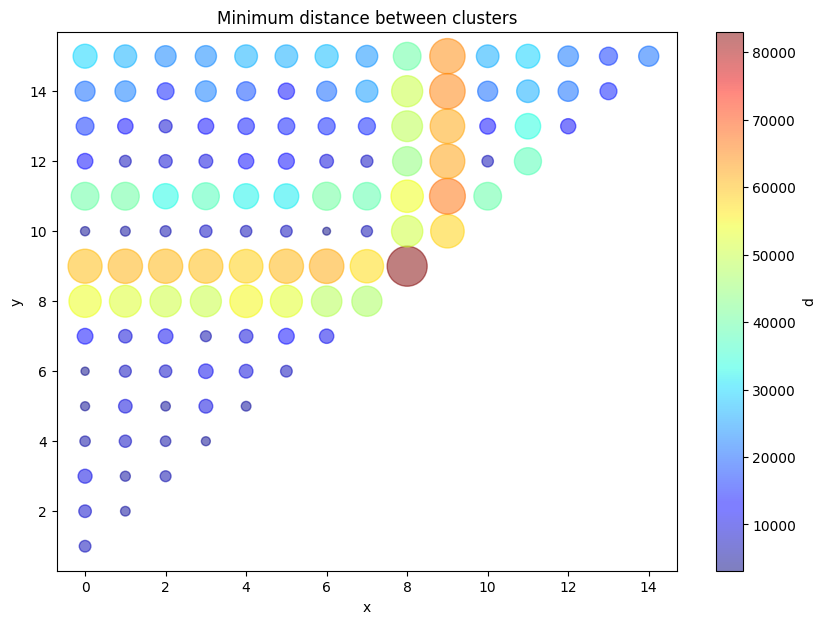

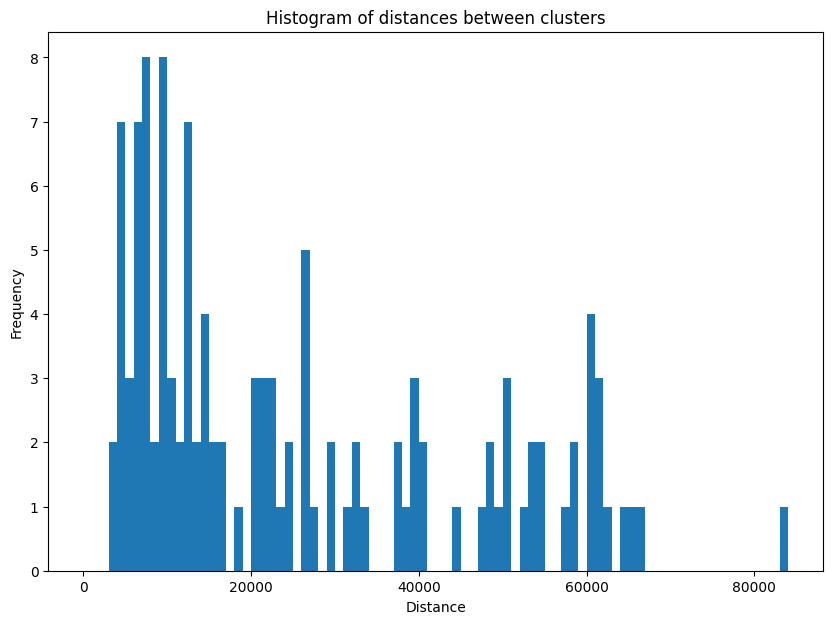

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


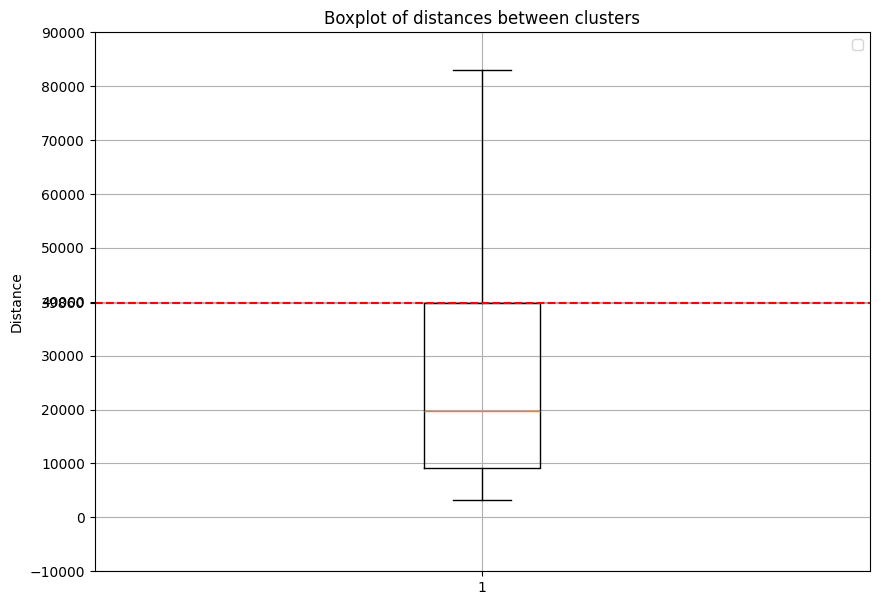

Mean: 25786.12
Std: 20105.76
Silhouette score: 0.3850


In [76]:
show_cluster_info(clusters2)

In [ ]:

threshold = 0.5
changed = True
while changed:
    changed = False
    for c1,c2 in list(combinations(range(len(clusters)), 2)):
        if is_cluster_close(clusters[c1], clusters[c2], threshold):
            clusters[c1] = merge_clusters(clusters[c1], clusters[c2])
            clusters.pop(c2)
            changed = True